In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
import timeit
import time
import scipy.signal
from scipy.signal import lfilter
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import chi2

In [2]:
print("Read data.....")
dataImport = pd.read_csv('data_siap.csv', sep=",")

Read data.....


In [3]:
status = dataImport.covid_status !=2
data2cov = dataImport[status]
data2cov

,Timestamp,PROCESS,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sampling_id,device_id,covid_status
0,15/03/2021 13:15,1,199,378,449,534,659,583,287,407,1028,11,0
1,15/03/2021 13:15,1,194,369,451,532,664,588,289,404,1028,11,0
2,15/03/2021 13:15,1,190,359,445,530,666,588,285,397,1028,11,0
3,15/03/2021 13:15,1,187,352,439,527,667,586,283,393,1028,11,0
4,15/03/2021 13:15,1,187,348,438,527,677,584,282,393,1028,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
686309,16/09/2021 06:03,3,453,283,277,291,340,646,414,436,11211,19,0
686310,16/09/2021 06:03,3,452,283,277,291,339,640,423,435,11211,19,0
686311,16/09/2021 06:03,3,451,283,277,292,338,647,423,435,11211,19,0
686312,16/09/2021 06:03,3,450,283,277,291,337,646,414,434,11211,19,0


In [4]:
proses1 = data2cov.PROCESS !=1
datap1 = data2cov[proses1]
proses2 = datap1.PROCESS !=3
datap2 = datap1[proses2]
datap3 = datap2.sort_values("sampling_id")
datap3

,Timestamp,PROCESS,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sampling_id,device_id,covid_status
153024,1/3/2021 8:11,2,394,531,376,574,821,883,466,432,457,2,1
153080,1/3/2021 8:13,2,399,523,376,562,807,877,466,432,457,2,1
153079,1/3/2021 8:13,2,391,524,378,562,808,877,466,432,457,2,1
153078,1/3/2021 8:12,2,392,523,376,562,807,877,464,431,457,2,1
153077,1/3/2021 8:12,2,391,524,377,563,807,886,466,432,457,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
686172,16/09/2021 06:03,2,531,340,351,337,435,688,485,511,11211,19,0
686171,16/09/2021 06:03,2,529,339,342,337,431,694,483,502,11211,19,0
686170,16/09/2021 06:03,2,529,340,343,337,433,693,484,510,11211,19,0
686182,16/09/2021 06:03,2,535,338,338,339,441,697,487,506,11211,19,0


In [5]:
dataSensor = datap3.drop(['Timestamp', 'PROCESS', 'device_id'], axis = 1)
dataSensor

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sampling_id,covid_status
153024,394,531,376,574,821,883,466,432,457,1
153080,399,523,376,562,807,877,466,432,457,1
153079,391,524,378,562,808,877,466,432,457,1
153078,392,523,376,562,807,877,464,431,457,1
153077,391,524,377,563,807,886,466,432,457,1
...,...,...,...,...,...,...,...,...,...,...
686172,531,340,351,337,435,688,485,511,11211,0
686171,529,339,342,337,431,694,483,502,11211,0
686170,529,340,343,337,433,693,484,510,11211,0
686182,535,338,338,339,441,697,487,506,11211,0


In [6]:
def outlier_treatment(datacolumn):
    sorted(datacolumn)
    Q1,Q3 = np.percentile(datacolumn , [25,75])
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    return lower_range,upper_range

In [48]:
sampling = 0
dataBersih = pd.DataFrame([])
for i in dataSensor.sampling_id:
    if i == sampling:
        continue
    else:
        sampling = i
#         print(i)
        dataGroup = dataSensor.groupby(dataSensor.sampling_id)
        dfAvg = dataGroup.get_group(i)
        a=0
        while(a<8):
            if dfAvg.empty:
                print(i)
                break
            sensor_1 = dfAvg.iloc[:,a]
            l,u = outlier_treatment(sensor_1)

            dfAvg = dfAvg[(dfAvg.iloc[:,a] < u) & (l < dfAvg.iloc[:,a])]
    #         print(dfAvg.shape)
            a = a+1
        dataBersih = pd.concat([dataBersih, dfAvg], ignore_index=True)

540
549
550
586
622
1433
1470
1472
1817
1856
2013
2171
2443
2620
2721
2865
3671
3689
3737
4437
4636
4858
4917
5229
5260
5279
5297
5445
5457
5745
6288
6847
6852
6995
7469
7567
7596
7796
7885
8044
8180
9597
9673
9686
10373


In [49]:
dataBersih

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sampling_id,covid_status
0,399,523,376,562,807,877,466,432,457,1
1,391,524,378,562,808,877,466,432,457,1
2,392,523,376,562,807,877,464,431,457,1
3,391,524,377,563,807,886,466,432,457,1
4,392,525,378,562,809,877,467,432,457,1
...,...,...,...,...,...,...,...,...,...,...
253062,531,340,351,337,435,688,485,511,11211,0
253063,529,339,342,337,431,694,483,502,11211,0
253064,529,340,343,337,433,693,484,510,11211,0
253065,535,338,338,339,441,697,487,506,11211,0


In [9]:
dataBersih.describe()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sampling_id,covid_status
count,253067.000000,253067.000000,253067.000000,253067.000000,253067.000000,253067.000000,253067.000000,253067.000000,253067.000000,253067.000000
mean,201.497528,438.614762,372.370819,576.997775,685.490214,673.312969,346.966436,415.317331,6119.227134,0.691208
std,65.695135,121.314540,84.869243,58.736557,80.684354,143.778165,101.369558,80.441331,2756.551550,0.461996
min,101.000000,168.000000,199.000000,299.000000,355.000000,215.000000,135.000000,220.000000,457.000000,0.000000
25%,163.000000,349.000000,310.000000,539.000000,632.000000,577.000000,260.000000,365.000000,4115.000000,0.000000
50%,184.000000,424.000000,361.000000,575.000000,680.000000,677.000000,345.000000,413.000000,6199.000000,1.000000
75%,217.000000,513.000000,442.000000,607.000000,740.000000,785.000000,429.000000,470.000000,8319.000000,1.000000
max,812.000000,964.000000,705.000000,863.000000,966.000000,1017.000000,805.000000,975.000000,11211.000000,1.000000


In [50]:
data_sensor = dataBersih.drop(['sampling_id', 'covid_status'], axis=1)
data_sensor

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8
0,399,523,376,562,807,877,466,432
1,391,524,378,562,808,877,466,432
2,392,523,376,562,807,877,464,431
3,391,524,377,563,807,886,466,432
4,392,525,378,562,809,877,467,432
...,...,...,...,...,...,...,...,...
253062,531,340,351,337,435,688,485,511
253063,529,339,342,337,431,694,483,502
253064,529,340,343,337,433,693,484,510
253065,535,338,338,339,441,697,487,506


In [51]:
data_status = dataBersih.iloc[:,[8,9]]
data_status

,sampling_id,covid_status
0,457,1
1,457,1
2,457,1
3,457,1
4,457,1
...,...,...
253062,11211,0
253063,11211,0
253064,11211,0
253065,11211,0


maximum level is 15


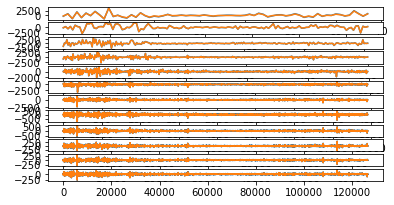

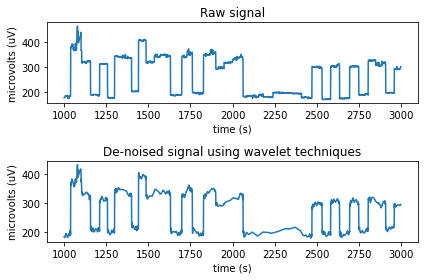

maximum level is 15


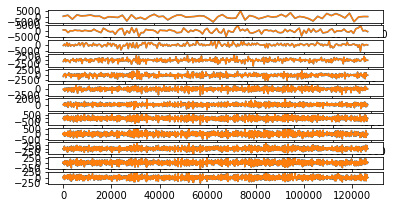

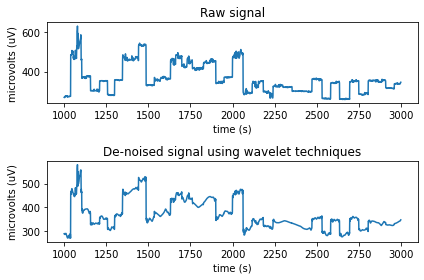

maximum level is 15


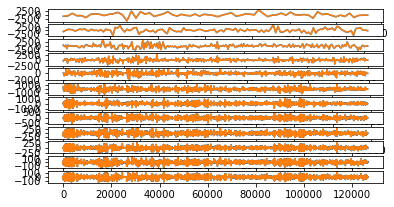

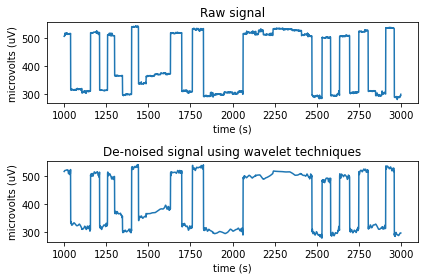

maximum level is 15


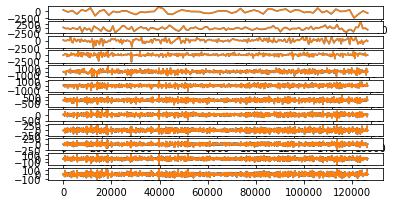

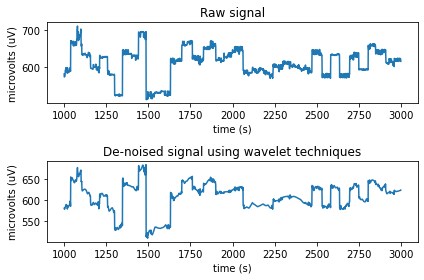

maximum level is 15


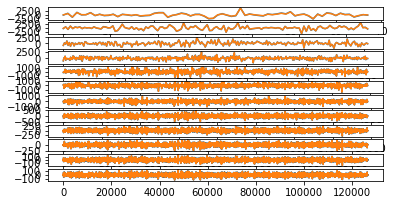

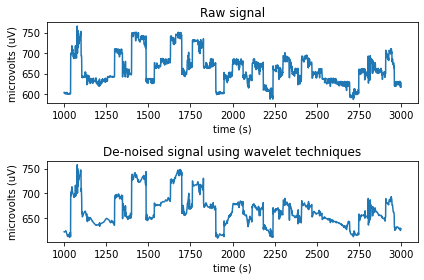

maximum level is 15


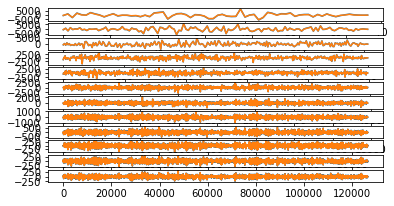

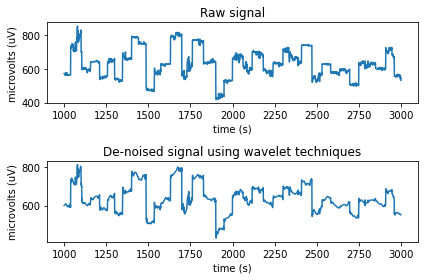

maximum level is 15


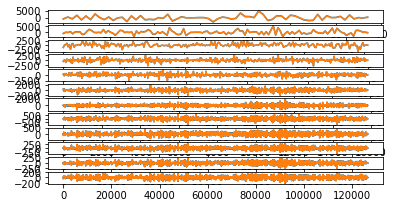

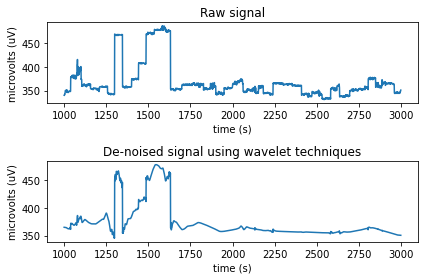

maximum level is 15


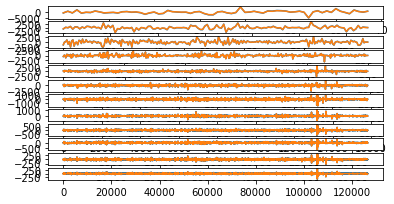

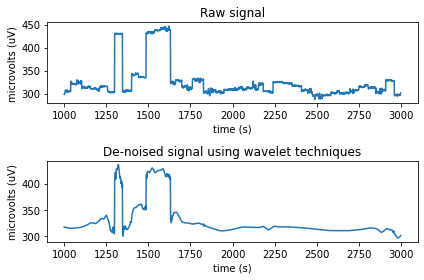

In [52]:
import pywt

dataWavelet = pd.DataFrame([])
for a in range(8):
    dataolah = data_sensor.iloc[:,a]
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(dataolah), w.dec_len)
    print("maximum level is " + str(maxlev))
    threshold = 0.04

    coeffs = pywt.wavedec(dataolah, 'sym4', level=12)
    plt.figure()
    for i in range(1, len(coeffs)):
        plt.subplot(maxlev, 1, i)
        plt.plot(coeffs[i])
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        plt.plot(coeffs[i])
    datarec = pywt.waverec(coeffs, 'sym4')

    mintime = 1000
    maxtime = mintime + 2000

    index = dataolah.index

    plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(index[mintime:maxtime], dataolah[mintime:maxtime])
    plt.xlabel('time (s)')
    plt.ylabel('microvolts (uV)')
    plt.title("Raw signal")
    plt.subplot(2, 1, 2)
    plt.plot(index[mintime:maxtime], datarec[mintime:maxtime])
    plt.xlabel('time (s)')
    plt.ylabel('microvolts (uV)')
    plt.title("De-noised signal using wavelet techniques")

    plt.tight_layout()
    plt.show()
    lihat = pd.DataFrame(datarec)
    dataWavelet[a]=lihat

In [40]:
# dataWav = dataWavelet.rename(columns={0:'sensor_1', 1:'sensor_2', 2:'sensor_3', 3:'sensor_4', 4:'sensor_5', 5:'sensor_6', 6:'sensor_7', 7:'sensor_8'})
dataWavelet

,0,1,2,3,4,5,6,7
0,391.247711,510.658836,371.235843,565.800420,797.075969,864.086551,460.934412,433.038523
1,391.325345,510.373079,371.704943,565.771698,796.819807,864.045303,461.068243,433.292125
2,391.388636,510.111735,372.103488,565.749554,796.604864,863.984431,461.185757,433.499929
3,391.326302,510.003256,372.071150,565.748299,796.564309,863.865176,461.164022,433.438955
4,391.204654,509.969388,371.832611,565.757920,796.665979,863.713711,461.077483,433.246178
...,...,...,...,...,...,...,...,...
253063,524.454131,326.793495,334.121114,336.979079,433.464049,694.684347,481.903275,491.673365
253064,524.556079,326.859132,332.469179,336.998097,432.204464,696.974933,481.942482,491.726165
253065,524.674952,326.919990,329.550667,337.018321,435.864435,700.951633,481.979751,491.784287
253066,524.803286,326.959388,326.786111,337.039238,432.835361,704.787833,482.015710,491.845337


In [22]:
dataWav

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8
0,391.247711,510.658836,371.235843,565.800420,797.075969,864.086551,460.934412,433.038523
1,391.325345,510.373079,371.704943,565.771698,796.819807,864.045303,461.068243,433.292125
2,391.388636,510.111735,372.103488,565.749554,796.604864,863.984431,461.185757,433.499929
3,391.326302,510.003256,372.071150,565.748299,796.564309,863.865176,461.164022,433.438955
4,391.204654,509.969388,371.832611,565.757920,796.665979,863.713711,461.077483,433.246178
...,...,...,...,...,...,...,...,...
253063,524.454131,326.793495,334.121114,336.979079,433.464049,694.684347,481.903275,491.673365
253064,524.556079,326.859132,332.469179,336.998097,432.204464,696.974933,481.942482,491.726165
253065,524.674952,326.919990,329.550667,337.018321,435.864435,700.951633,481.979751,491.784287
253066,524.803286,326.959388,326.786111,337.039238,432.835361,704.787833,482.015710,491.845337


In [41]:
data = dataWavelet.join(data_status)
data

,0,1,2,3,4,5,6,7,sampling_id,covid_status
0,391.247711,510.658836,371.235843,565.800420,797.075969,864.086551,460.934412,433.038523,457.0,1.0
1,391.325345,510.373079,371.704943,565.771698,796.819807,864.045303,461.068243,433.292125,457.0,1.0
2,391.388636,510.111735,372.103488,565.749554,796.604864,863.984431,461.185757,433.499929,457.0,1.0
3,391.326302,510.003256,372.071150,565.748299,796.564309,863.865176,461.164022,433.438955,457.0,1.0
4,391.204654,509.969388,371.832611,565.757920,796.665979,863.713711,461.077483,433.246178,457.0,1.0
...,...,...,...,...,...,...,...,...,...,...
253063,524.454131,326.793495,334.121114,336.979079,433.464049,694.684347,481.903275,491.673365,11211.0,0.0
253064,524.556079,326.859132,332.469179,336.998097,432.204464,696.974933,481.942482,491.726165,11211.0,0.0
253065,524.674952,326.919990,329.550667,337.018321,435.864435,700.951633,481.979751,491.784287,11211.0,0.0
253066,524.803286,326.959388,326.786111,337.039238,432.835361,704.787833,482.015710,491.845337,11211.0,0.0


In [53]:
datamean = data.groupby('sampling_id').agg(np.mean)
datamean

,0,1,2,3,4,5,6,7,covid_status
sampling_id,,,,,,,,,
457.0,393.137241,509.189509,370.495838,567.461768,802.872233,856.153601,463.664560,431.143720,1.0
468.0,463.723509,439.126817,517.667072,577.075219,818.685740,817.824619,539.324706,491.703297,0.0
470.0,393.946770,378.544319,465.915204,565.258241,783.431697,781.810517,510.880197,472.616792,1.0
488.0,331.772989,339.837946,378.295144,542.133611,660.706066,592.709704,473.856209,436.165222,1.0
489.0,307.225627,309.957133,363.514458,527.743689,635.721924,557.644793,456.747090,422.458127,1.0
...,...,...,...,...,...,...,...,...,...
11207.0,460.849549,363.771381,324.444130,340.357980,382.374903,629.912493,422.772413,439.765928,0.0
11208.0,452.506502,328.761260,321.818051,318.986439,379.123369,633.865161,425.917673,434.656908,0.0
11209.0,477.878824,318.227317,329.449576,329.982037,396.100635,647.879030,448.407895,462.604242,0.0


In [55]:
x = datamean.iloc[:,:8]
y = datamean.iloc[:,8]

# scaler = StandardScaler()
# scaler.fit(x, y)

cv = KFold(n_splits=5, random_state=1, shuffle=True)
model =   RandomForestClassifier(n_estimators=64)

scores = cross_val_score(model, x, y, scoring='accuracy',
                         cv=cv, n_jobs=-1)

print("Cross-validation scores: ", scores)
print("Mean cross-validation score: ", scores.mean())

Cross-validation scores:  [0.73462783 0.77022654 0.74325782 0.78401728 0.75161987]
Mean cross-validation score:  0.756749867777568


In [57]:
x = datamean.iloc[:,:8]
y = datamean.iloc[:,8]

scaler = StandardScaler()
scaler.fit(x, y)

cv = KFold(n_splits=5, random_state=1, shuffle=True)
model =   RandomForestClassifier(n_estimators=64)

scores = cross_val_score(model, x, y, scoring='accuracy',
                         cv=cv, n_jobs=-1)

print("Cross-validation scores: ", scores)
print("Mean cross-validation score: ", scores.mean())

Cross-validation scores:  [0.74649407 0.7562028  0.75512406 0.77429806 0.7537797 ]
Mean cross-validation score:  0.7571797363007076


In [45]:
data_y = datamean.iloc[:,8]
data_y

sampling_id
457.0      1.0
468.0      0.0
470.0      1.0
488.0      1.0
489.0      1.0
          ... 
11207.0    0.0
11208.0    0.0
11209.0    0.0
11210.0    0.0
11211.0    0.0
Name: covid_status, Length: 4633, dtype: float64

In [58]:
data1 = data.drop(253067)
data2 = data1.drop(['covid_status'], axis=1)
data2

,0,1,2,3,4,5,6,7,sampling_id
0,391.247711,510.658836,371.235843,565.800420,797.075969,864.086551,460.934412,433.038523,457.0
1,391.325345,510.373079,371.704943,565.771698,796.819807,864.045303,461.068243,433.292125,457.0
2,391.388636,510.111735,372.103488,565.749554,796.604864,863.984431,461.185757,433.499929,457.0
3,391.326302,510.003256,372.071150,565.748299,796.564309,863.865176,461.164022,433.438955,457.0
4,391.204654,509.969388,371.832611,565.757920,796.665979,863.713711,461.077483,433.246178,457.0
...,...,...,...,...,...,...,...,...,...
253062,524.361631,326.725010,335.334593,336.960775,433.721450,693.147075,481.862536,491.623385,11211.0
253063,524.454131,326.793495,334.121114,336.979079,433.464049,694.684347,481.903275,491.673365,11211.0
253064,524.556079,326.859132,332.469179,336.998097,432.204464,696.974933,481.942482,491.726165,11211.0
253065,524.674952,326.919990,329.550667,337.018321,435.864435,700.951633,481.979751,491.784287,11211.0


In [59]:
dataMean2 = data2.groupby('sampling_id').agg(np.mean)
dataMean2 = dataMean2.rename(columns={0:'mean_1',1:'mean_2', 2:'mean_3', 3:'mean_4', 4:'mean_5', 5:'mean_6', 6:'mean_7', 7:'mean_8'})
dataMin = data2.groupby('sampling_id').agg(np.min)
dataMin = dataMin.rename(columns={0:'min_1',1:'min_2', 2:'min_3', 3:'min_4', 4:'min_5', 5:'min_6', 6:'min_7', 7:'min_8'})
dataMax = data2.groupby('sampling_id').agg(np.max)
dataMax = dataMax.rename(columns={0:'max_1',1:'max_2', 2:'max_3', 3:'max_4', 4:'max_5', 5:'max_6', 6:'max_7', 7:'max_8'})
data_mean_min = dataMean2.join(dataMin)
data_mean_min_max = data_mean_min.join(dataMax)
data_mean_min_max

,mean_1,mean_2,mean_3,mean_4,mean_5,mean_6,mean_7,mean_8,min_1,min_2,...,min_7,min_8,max_1,max_2,max_3,max_4,max_5,max_6,max_7,max_8
sampling_id,,,,,,,,,,,,,,,,,,,,,
457.0,393.137241,509.189509,370.495838,567.461768,802.872233,856.153601,463.664560,431.143720,388.377717,500.834177,...,459.076430,423.125335,406.076726,516.170401,381.734848,571.660755,811.177588,864.086551,473.971714,443.544728
468.0,463.723509,439.126817,517.667072,577.075219,818.685740,817.824619,539.324706,491.703297,452.216816,422.582567,...,531.664873,481.139507,472.000479,464.627151,526.313975,580.509717,824.725516,828.287190,551.892101,497.483594
470.0,393.946770,378.544319,465.915204,565.258241,783.431697,781.810517,510.880197,472.616792,385.785601,372.635110,...,506.245063,463.346211,403.079768,388.347610,475.928823,572.840179,791.808005,792.126409,517.650827,479.598331
488.0,331.772989,339.837946,378.295144,542.133611,660.706066,592.709704,473.856209,436.165222,313.730289,319.035253,...,463.699898,427.490511,342.334863,353.081895,383.460187,549.558820,667.509663,611.959774,480.491543,444.551776
489.0,307.225627,309.957133,363.514458,527.743689,635.721924,557.644793,456.747090,422.458127,299.760006,295.900623,...,451.150338,416.392049,318.376922,317.308239,369.856269,532.181282,645.843636,575.037202,462.873008,431.084356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11207.0,460.849549,363.771381,324.444130,340.357980,382.374903,629.912493,422.772413,439.765928,442.351248,357.682987,...,414.979035,426.014357,469.377128,372.283886,328.739677,348.265053,391.374774,641.434324,428.519422,452.380734
11208.0,452.506502,328.761260,321.818051,318.986439,379.123369,633.865161,425.917673,434.656908,440.706546,321.008543,...,420.063466,426.761060,466.789442,336.049021,334.988706,327.184237,389.043985,642.089469,435.443209,447.309085
11209.0,477.878824,318.227317,329.449576,329.982037,396.100635,647.879030,448.407895,462.604242,467.572680,316.891245,...,435.836697,447.864268,481.198500,320.981292,336.140151,334.876286,401.440069,652.815537,458.615940,473.019465


In [60]:
x = data_mean_min
y = data_y

scaler = StandardScaler()
scaler.fit(x, y)

cv = KFold(n_splits=5, random_state=1, shuffle=True)
model =   RandomForestClassifier(n_estimators=64)

scores = cross_val_score(model, x, y, scoring='accuracy',
                         cv=cv, n_jobs=-1)

print("Cross-validation scores: ", scores)
print("Mean cross-validation score: ", scores.mean())

Cross-validation scores:  [0.73894283 0.76483279 0.74110032 0.77321814 0.75269978]
Mean cross-validation score:  0.7541587740941889


In [63]:
x = data_mean_min_max
y = data_y

scaler = StandardScaler()
scaler.fit(x, y)

cv = KFold(n_splits=5, random_state=1, shuffle=True)
model =   RandomForestClassifier(n_estimators=64)

scores = cross_val_score(model, x, y, scoring='accuracy',
                         cv=cv, n_jobs=-1)

print("Cross-validation scores: ", scores)
print("Mean cross-validation score: ", scores.mean())

Cross-validation scores:  [0.74541532 0.77238403 0.74865156 0.78185745 0.75161987]
Mean cross-validation score:  0.7599856477501217


In [65]:
def correlation(dataset, threshold):
    col_corr = set()  
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: 
                colname = corr_matrix.columns[i]  
                col_corr.add(colname)
    return col_corr

In [66]:
corr_features = correlation(x, 0.9)
print(len(set(corr_features)))
print(corr_features)

16
{'min_3', 'max_2', 'max_8', 'max_5', 'min_6', 'max_3', 'min_4', 'min_5', 'min_2', 'max_1', 'min_7', 'max_7', 'max_4', 'min_1', 'min_8', 'max_6'}


In [68]:
pearson_mean_min_max = x[['min_3', 'max_2', 'max_8', 'max_5', 'min_6', 'max_3', 'min_4', 'min_5', 'min_2', 'max_1', 'min_7', 'max_7', 'max_4', 'min_1', 'min_8', 'max_6']]
pearson_mean_min_max

,min_3,max_2,max_8,max_5,min_6,max_3,min_4,min_5,min_2,max_1,min_7,max_7,max_4,min_1,min_8,max_6
sampling_id,,,,,,,,,,,,,,,,
457.0,362.121074,516.170401,443.544728,811.177588,846.721302,381.734848,565.748299,796.499221,500.834177,406.076726,459.076430,473.971714,571.660755,388.377717,423.125335,864.086551
468.0,510.698325,464.627151,497.483594,824.725516,809.833048,526.313975,571.539962,814.787959,422.582567,472.000479,531.664873,551.892101,580.509717,452.216816,481.139507,828.287190
470.0,453.510705,388.347610,479.598331,791.808005,772.578296,475.928823,560.979480,777.712219,372.635110,403.079768,506.245063,517.650827,572.840179,385.785601,463.346211,792.126409
488.0,370.532541,353.081895,444.551776,667.509663,570.694958,383.460187,533.087671,647.430405,319.035253,342.334863,463.699898,480.491543,549.558820,313.730289,427.490511,611.959774
489.0,360.711981,317.308239,431.084356,645.843636,544.811130,369.856269,519.768093,628.149597,295.900623,318.376922,451.150338,462.873008,532.181282,299.760006,416.392049,575.037202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11207.0,321.658261,372.283886,452.380734,391.374774,626.196583,328.739677,336.148125,378.480269,357.682987,469.377128,414.979035,428.519422,348.265053,442.351248,426.014357,641.434324
11208.0,317.202828,336.049021,447.309085,389.043985,625.056366,334.988706,311.470556,371.154916,321.008543,466.789442,420.063466,435.443209,327.184237,440.706546,426.761060,642.089469
11209.0,318.670381,320.981292,473.019465,401.440069,641.328955,336.140151,323.822445,389.434588,316.891245,481.198500,435.836697,458.615940,334.876286,467.572680,447.864268,652.815537


In [74]:
x = pearson_mean_min_max
y = data_y

scaler = StandardScaler()
scaler.fit(x, y)

cv = KFold(n_splits=5, random_state=1, shuffle=True)
model =   RandomForestClassifier(n_estimators=64)

scores = cross_val_score(model, x, y, scoring='accuracy',
                         cv=cv, n_jobs=-1)

print("Cross-validation scores: ", scores)
print("Mean cross-validation score: ", scores.mean())

Cross-validation scores:  [0.74973031 0.76699029 0.74649407 0.77969762 0.75269978]
Mean cross-validation score:  0.7591224158378009


In [83]:
dataStd = data2.groupby('sampling_id').agg(np.std)
dataStd = dataStd.rename(columns={0:'std_1', 1:'std_2', 2:'std_3', 3:'std_4', 4:'std_5', 5:'std_6', 6:'std_7', 7:'std_8'})
data_mean_min_max_std = data_mean_min_max.join(dataStd)
data_mean_min_max_std

,mean_1,mean_2,mean_3,mean_4,mean_5,mean_6,mean_7,mean_8,min_1,min_2,...,max_7,max_8,std_1,std_2,std_3,std_4,std_5,std_6,std_7,std_8
sampling_id,,,,,,,,,,,,,,,,,,,,,
457.0,393.137241,509.189509,370.495838,567.461768,802.872233,856.153601,463.664560,431.143720,388.377717,500.834177,...,473.971714,443.544728,4.990762,2.855487,4.804790,1.600660,4.692180,5.729522,4.629790,5.037150
468.0,463.723509,439.126817,517.667072,577.075219,818.685740,817.824619,539.324706,491.703297,452.216816,422.582567,...,551.892101,497.483594,5.094708,11.262149,3.858163,2.278671,1.901129,3.936695,5.047556,4.734286
470.0,393.946770,378.544319,465.915204,565.258241,783.431697,781.810517,510.880197,472.616792,385.785601,372.635110,...,517.650827,479.598331,4.764705,4.204403,5.930204,2.381338,3.368443,5.695971,2.764854,4.652217
488.0,331.772989,339.837946,378.295144,542.133611,660.706066,592.709704,473.856209,436.165222,313.730289,319.035253,...,480.491543,444.551776,6.566257,8.532313,4.214470,4.020542,5.081980,9.881010,3.874459,3.286057
489.0,307.225627,309.957133,363.514458,527.743689,635.721924,557.644793,456.747090,422.458127,299.760006,295.900623,...,462.873008,431.084356,5.670603,4.606003,2.320624,2.133071,4.508254,8.153649,3.629756,4.202929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11207.0,460.849549,363.771381,324.444130,340.357980,382.374903,629.912493,422.772413,439.765928,442.351248,357.682987,...,428.519422,452.380734,4.599452,3.040682,1.406969,3.318943,3.218238,3.868630,2.755876,7.331870
11208.0,452.506502,328.761260,321.818051,318.986439,379.123369,633.865161,425.917673,434.656908,440.706546,321.008543,...,435.443209,447.309085,6.524158,4.073303,3.983028,4.158877,5.185462,5.818304,3.826633,5.229725
11209.0,477.878824,318.227317,329.449576,329.982037,396.100635,647.879030,448.407895,462.604242,467.572680,316.891245,...,458.615940,473.019465,3.118838,1.333371,3.827012,2.926813,2.825224,3.085575,6.368578,6.610505


In [84]:
x = data_mean_min_max_std
y = data_y

scaler = StandardScaler()
scaler.fit(x, y)

cv = KFold(n_splits=5, random_state=1, shuffle=True)
model =   RandomForestClassifier(n_estimators=64)

scores = cross_val_score(model, x, y, scoring='accuracy',
                         cv=cv, n_jobs=-1)

print("Cross-validation scores: ", scores)
print("Mean cross-validation score: ", scores.mean())

Cross-validation scores:  [0.75188781 0.76591154 0.74973031 0.77537797 0.76673866]
Mean cross-validation score:  0.7619292592514929


In [85]:
corr_features = correlation(x, 0.9)
print(len(set(corr_features)))
print(corr_features)

16
{'min_3', 'max_2', 'max_8', 'max_5', 'min_6', 'max_3', 'min_4', 'min_5', 'min_2', 'max_1', 'min_7', 'max_7', 'max_4', 'min_1', 'min_8', 'max_6'}


In [86]:
pearson_mean_min_max_std = x[['min_3', 'max_2', 'max_8', 'max_5', 'min_6', 'max_3', 'min_4', 'min_5', 'min_2', 'max_1', 'min_7', 'max_7', 'max_4', 'min_1', 'min_8', 'max_6']]

In [87]:
x = pearson_mean_min_max_std
y = data_y

scaler = StandardScaler()
scaler.fit(x, y)

cv = KFold(n_splits=5, random_state=1, shuffle=True)
model =   RandomForestClassifier(n_estimators=64)

scores = cross_val_score(model, x, y, scoring='accuracy',
                         cv=cv, n_jobs=-1)

print("Cross-validation scores: ", scores)
print("Mean cross-validation score: ", scores.mean())

Cross-validation scores:  [0.75188781 0.77130529 0.74325782 0.78509719 0.7537797 ]
Mean cross-validation score:  0.7610655613570332


In [88]:
x = dataStd
y = data_y

scaler = StandardScaler()
scaler.fit(x, y)

cv = KFold(n_splits=5, random_state=1, shuffle=True)
model =   RandomForestClassifier(n_estimators=64)

scores = cross_val_score(model, x, y, scoring='accuracy',
                         cv=cv, n_jobs=-1)

print("Cross-validation scores: ", scores)
print("Mean cross-validation score: ", scores.mean())

Cross-validation scores:  [0.67745415 0.69039914 0.69579288 0.71598272 0.67170626]
Mean cross-validation score:  0.6902670310646992


In [89]:
sampling = 0
datakurtosis = pd.DataFrame([])
for samp in data2.sampling_id:
    dataaa = pd.DataFrame([])
    if samp == sampling:
        continue
    else:
        print(samp)
        newdataKurto = data2.groupby('sampling_id')
        data1 = newdataKurto.get_group(samp)
        for j in range(8):
            data=[]
            data.append(data1.iloc[:,j].kurtosis())
            dataaa[j]=data
        sampling = samp
    datakurtosis = pd.concat([datakurtosis, dataaa], ignore_index = False)

457.0
468.0
470.0
488.0
489.0
490.0
492.0
493.0
494.0
495.0
496.0
497.0
498.0
499.0
500.0
501.0
536.0
537.0
538.0
539.0
541.0
542.0
543.0
544.0
545.0
546.0
547.0
548.0
551.0
552.0
553.0
554.0
555.0
556.0
557.0
558.0
559.0
560.0
567.0
568.0
569.0
570.0
571.0
572.0
573.0
574.0
575.0
576.0
577.0
578.0
579.0
580.0
581.0
582.0
583.0
584.0
585.0
587.0
588.0
589.0
590.0
591.0
596.0
597.0
598.0
599.0
600.0
601.0
602.0
603.0
604.0
605.0
607.0
616.0
617.0
618.0
619.0
620.0
621.0
623.0
624.0
625.0
626.0
627.0
628.0
629.0
630.0
631.0
632.0
634.0
635.0
636.0
637.0
638.0
639.0
640.0
641.0
642.0
643.0
652.0
653.0
654.0
655.0
656.0
657.0
658.0
659.0
660.0
661.0
662.0
663.0
664.0
665.0
666.0
667.0
668.0
669.0
670.0
671.0
672.0
673.0
674.0
675.0
679.0
680.0
681.0
689.0
690.0
691.0
692.0
693.0
695.0
696.0
697.0
698.0
699.0
700.0
701.0
702.0
703.0
704.0
705.0
706.0
707.0
708.0
709.0
710.0
711.0
712.0
713.0
714.0
715.0
716.0
717.0
718.0
719.0
720.0
721.0
722.0
723.0
724.0
726.0
727.0
728.0
729.0
730.0
731.

4280.0
4281.0
4282.0
4283.0
4284.0
4285.0
4287.0
4288.0
4295.0
4296.0
4300.0
4301.0
4302.0
4304.0
4306.0
4308.0
4309.0
4311.0
4323.0
4324.0
4325.0
4326.0
4327.0
4328.0
4329.0
4330.0
4331.0
4332.0
4333.0
4334.0
4335.0
4336.0
4344.0
4345.0
4346.0
4347.0
4348.0
4349.0
4350.0
4351.0
4352.0
4353.0
4354.0
4366.0
4367.0
4368.0
4369.0
4371.0
4372.0
4374.0
4376.0
4378.0
4380.0
4388.0
4389.0
4390.0
4391.0
4392.0
4393.0
4394.0
4396.0
4399.0
4400.0
4402.0
4404.0
4408.0
4410.0
4414.0
4416.0
4419.0
4425.0
4432.0
4433.0
4434.0
4435.0
4436.0
4438.0
4463.0
4464.0
4465.0
4466.0
4473.0
4475.0
4478.0
4479.0
4480.0
4483.0
4558.0
4559.0
4560.0
4561.0
4562.0
4563.0
4564.0
4565.0
4566.0
4569.0
4572.0
4576.0
4578.0
4580.0
4582.0
4586.0
4588.0
4590.0
4591.0
4593.0
4602.0
4605.0
4606.0
4607.0
4608.0
4609.0
4610.0
4611.0
4612.0
4613.0
4614.0
4615.0
4616.0
4617.0
4618.0
4619.0
4621.0
4622.0
4624.0
4625.0
4627.0
4629.0
4631.0
4634.0
4637.0
4638.0
4639.0
4640.0
4641.0
4642.0
4643.0
4644.0
4645.0
4646.0
4647.0
4648.0

6475.0
6476.0
6477.0
6478.0
6479.0
6480.0
6481.0
6482.0
6483.0
6484.0
6485.0
6486.0
6487.0
6488.0
6489.0
6490.0
6492.0
6493.0
6494.0
6495.0
6497.0
6498.0
6499.0
6500.0
6501.0
6502.0
6503.0
6504.0
6505.0
6506.0
6507.0
6533.0
6534.0
6535.0
6536.0
6537.0
6538.0
6539.0
6540.0
6542.0
6543.0
6544.0
6545.0
6546.0
6566.0
6567.0
6568.0
6569.0
6570.0
6571.0
6572.0
6573.0
6574.0
6575.0
6576.0
6577.0
6578.0
6579.0
6580.0
6581.0
6582.0
6583.0
6584.0
6585.0
6587.0
6589.0
6626.0
6628.0
6629.0
6630.0
6631.0
6632.0
6633.0
6634.0
6635.0
6636.0
6637.0
6638.0
6639.0
6640.0
6641.0
6642.0
6643.0
6645.0
6647.0
6648.0
6649.0
6650.0
6651.0
6652.0
6653.0
6654.0
6655.0
6657.0
6658.0
6659.0
6660.0
6661.0
6662.0
6663.0
6664.0
6665.0
6666.0
6667.0
6668.0
6669.0
6670.0
6671.0
6696.0
6697.0
6700.0
6701.0
6704.0
6706.0
6708.0
6709.0
6711.0
6712.0
6713.0
6714.0
6715.0
6717.0
6718.0
6719.0
6720.0
6721.0
6723.0
6724.0
6725.0
6726.0
6727.0
6728.0
6729.0
6730.0
6731.0
6733.0
6734.0
6735.0
6736.0
6737.0
6738.0
6739.0
6740.0

8458.0
8460.0
8461.0
8462.0
8463.0
8464.0
8465.0
8466.0
8467.0
8468.0
8469.0
8470.0
8478.0
8488.0
8489.0
8494.0
8497.0
8498.0
8501.0
8504.0
8505.0
8506.0
8511.0
8512.0
8513.0
8518.0
8523.0
8524.0
8526.0
8527.0
8528.0
8529.0
8530.0
8531.0
8533.0
8534.0
8536.0
8537.0
8539.0
8540.0
8541.0
8542.0
8543.0
8545.0
8546.0
8547.0
8548.0
8549.0
8550.0
8551.0
8552.0
8554.0
8555.0
8556.0
8557.0
8558.0
8559.0
8560.0
8561.0
8562.0
8563.0
8564.0
8565.0
8569.0
8570.0
8589.0
8590.0
8591.0
8592.0
8593.0
8594.0
8597.0
8598.0
8599.0
8600.0
8601.0
8602.0
8603.0
8604.0
8605.0
8606.0
8607.0
8608.0
8609.0
8610.0
8611.0
8612.0
8614.0
8616.0
8618.0
8620.0
8625.0
8627.0
8628.0
8629.0
8632.0
8634.0
8638.0
8639.0
8643.0
8644.0
8645.0
8651.0
8652.0
8660.0
8661.0
8662.0
8663.0
8666.0
8668.0
8670.0
8674.0
8676.0
8680.0
8682.0
8683.0
8684.0
8687.0
8688.0
8689.0
8692.0
8696.0
8698.0
8700.0
8711.0
8712.0
8713.0
8714.0
8715.0
8716.0
8717.0
8718.0
8719.0
8720.0
8722.0
8723.0
8724.0
8725.0
8726.0
8727.0
8728.0
8729.0
8731.0

In [90]:
datakurtosis = datakurtosis.rename(columns={0:'kurto_1', 1:'kurto_2', 2:'kurto_3', 3:'kurto_4', 4:'kurto_4', 5:'kurto_6', 6:'kurto_7', 7:'kurto_8'})
datakurtosis.reset_index(inplace=True)
datakurtosis2 = datakurtosis.drop(['index'], axis=1)
datakurtosis2

,kurto_1,kurto_2,kurto_3,kurto_4,kurto_4,kurto_6,kurto_7,kurto_8
0,0.241168,2.159991,-0.236467,-0.386381,-1.420769,-1.388626,-0.310259,-0.310521
1,-0.430487,-0.454865,-0.362496,-0.483649,1.304981,1.108756,-0.021883,-0.992027
2,-1.014392,-0.999999,-0.995165,0.127262,-0.595835,-1.146970,-0.219819,-1.271172
3,1.104540,0.024978,-1.305415,-0.499669,-0.279872,-0.588891,0.560896,1.401240
4,-1.117622,0.546995,0.449647,2.716525,-0.247827,-0.964435,-1.291085,-1.061487
...,...,...,...,...,...,...,...,...
4628,3.624152,0.195337,0.294111,-0.432151,1.281967,2.338997,1.514349,-1.030144
4629,-0.641451,-0.408211,3.559132,-1.024523,-1.251497,-1.542065,-0.002567,-0.237233
4630,1.947420,-1.052082,-0.854026,-0.597139,0.180727,-1.106777,-0.982183,-0.539559
4631,-1.424015,4.436115,1.324744,-1.284945,-0.128309,-1.169608,-1.378922,2.358142


In [92]:
x = datakurtosis2
y = data_y

scaler = StandardScaler()
scaler.fit(x, y)

cv = KFold(n_splits=5, random_state=1, shuffle=True)
model =   RandomForestClassifier(n_estimators=64)

scores = cross_val_score(model, x, y, scoring='accuracy',
                         cv=cv, n_jobs=-1)

print("Cross-validation scores: ", scores)
print("Mean cross-validation score: ", scores.mean())

Cross-validation scores:  [0.67529666 0.67098166 0.68716289 0.70086393 0.6587473 ]
Mean cross-validation score:  0.6786104878600003


In [93]:
sampling = 0
dataskew = pd.DataFrame([])
for samp in data2.sampling_id:
    dataaa = pd.DataFrame([])
    if samp == sampling:
        continue
    else:
        print(samp)
        newdataskew = data2.groupby('sampling_id')
        data1 = newdataskew.get_group(samp)
        for j in range(8):
            data=[]
            data.append(data1.iloc[:,j].skew())
            dataaa[j]=data
        sampling = samp
    dataskew = pd.concat([dataskew, dataaa], ignore_index = False)

457.0
468.0
470.0
488.0
489.0
490.0
492.0
493.0
494.0
495.0
496.0
497.0
498.0
499.0
500.0
501.0
536.0
537.0
538.0
539.0
541.0
542.0
543.0
544.0
545.0
546.0
547.0
548.0
551.0
552.0
553.0
554.0
555.0
556.0
557.0
558.0
559.0
560.0
567.0
568.0
569.0
570.0
571.0
572.0
573.0
574.0
575.0
576.0
577.0
578.0
579.0
580.0
581.0
582.0
583.0
584.0
585.0
587.0
588.0
589.0
590.0
591.0
596.0
597.0
598.0
599.0
600.0
601.0
602.0
603.0
604.0
605.0
607.0
616.0
617.0
618.0
619.0
620.0
621.0
623.0
624.0
625.0
626.0
627.0
628.0
629.0
630.0
631.0
632.0
634.0
635.0
636.0
637.0
638.0
639.0
640.0
641.0
642.0
643.0
652.0
653.0
654.0
655.0
656.0
657.0
658.0
659.0
660.0
661.0
662.0
663.0
664.0
665.0
666.0
667.0
668.0
669.0
670.0
671.0
672.0
673.0
674.0
675.0
679.0
680.0
681.0
689.0
690.0
691.0
692.0
693.0
695.0
696.0
697.0
698.0
699.0
700.0
701.0
702.0
703.0
704.0
705.0
706.0
707.0
708.0
709.0
710.0
711.0
712.0
713.0
714.0
715.0
716.0
717.0
718.0
719.0
720.0
721.0
722.0
723.0
724.0
726.0
727.0
728.0
729.0
730.0
731.

4280.0
4281.0
4282.0
4283.0
4284.0
4285.0
4287.0
4288.0
4295.0
4296.0
4300.0
4301.0
4302.0
4304.0
4306.0
4308.0
4309.0
4311.0
4323.0
4324.0
4325.0
4326.0
4327.0
4328.0
4329.0
4330.0
4331.0
4332.0
4333.0
4334.0
4335.0
4336.0
4344.0
4345.0
4346.0
4347.0
4348.0
4349.0
4350.0
4351.0
4352.0
4353.0
4354.0
4366.0
4367.0
4368.0
4369.0
4371.0
4372.0
4374.0
4376.0
4378.0
4380.0
4388.0
4389.0
4390.0
4391.0
4392.0
4393.0
4394.0
4396.0
4399.0
4400.0
4402.0
4404.0
4408.0
4410.0
4414.0
4416.0
4419.0
4425.0
4432.0
4433.0
4434.0
4435.0
4436.0
4438.0
4463.0
4464.0
4465.0
4466.0
4473.0
4475.0
4478.0
4479.0
4480.0
4483.0
4558.0
4559.0
4560.0
4561.0
4562.0
4563.0
4564.0
4565.0
4566.0
4569.0
4572.0
4576.0
4578.0
4580.0
4582.0
4586.0
4588.0
4590.0
4591.0
4593.0
4602.0
4605.0
4606.0
4607.0
4608.0
4609.0
4610.0
4611.0
4612.0
4613.0
4614.0
4615.0
4616.0
4617.0
4618.0
4619.0
4621.0
4622.0
4624.0
4625.0
4627.0
4629.0
4631.0
4634.0
4637.0
4638.0
4639.0
4640.0
4641.0
4642.0
4643.0
4644.0
4645.0
4646.0
4647.0
4648.0

6473.0
6475.0
6476.0
6477.0
6478.0
6479.0
6480.0
6481.0
6482.0
6483.0
6484.0
6485.0
6486.0
6487.0
6488.0
6489.0
6490.0
6492.0
6493.0
6494.0
6495.0
6497.0
6498.0
6499.0
6500.0
6501.0
6502.0
6503.0
6504.0
6505.0
6506.0
6507.0
6533.0
6534.0
6535.0
6536.0
6537.0
6538.0
6539.0
6540.0
6542.0
6543.0
6544.0
6545.0
6546.0
6566.0
6567.0
6568.0
6569.0
6570.0
6571.0
6572.0
6573.0
6574.0
6575.0
6576.0
6577.0
6578.0
6579.0
6580.0
6581.0
6582.0
6583.0
6584.0
6585.0
6587.0
6589.0
6626.0
6628.0
6629.0
6630.0
6631.0
6632.0
6633.0
6634.0
6635.0
6636.0
6637.0
6638.0
6639.0
6640.0
6641.0
6642.0
6643.0
6645.0
6647.0
6648.0
6649.0
6650.0
6651.0
6652.0
6653.0
6654.0
6655.0
6657.0
6658.0
6659.0
6660.0
6661.0
6662.0
6663.0
6664.0
6665.0
6666.0
6667.0
6668.0
6669.0
6670.0
6671.0
6696.0
6697.0
6700.0
6701.0
6704.0
6706.0
6708.0
6709.0
6711.0
6712.0
6713.0
6714.0
6715.0
6717.0
6718.0
6719.0
6720.0
6721.0
6723.0
6724.0
6725.0
6726.0
6727.0
6728.0
6729.0
6730.0
6731.0
6733.0
6734.0
6735.0
6736.0
6737.0
6738.0
6739.0

8457.0
8458.0
8460.0
8461.0
8462.0
8463.0
8464.0
8465.0
8466.0
8467.0
8468.0
8469.0
8470.0
8478.0
8488.0
8489.0
8494.0
8497.0
8498.0
8501.0
8504.0
8505.0
8506.0
8511.0
8512.0
8513.0
8518.0
8523.0
8524.0
8526.0
8527.0
8528.0
8529.0
8530.0
8531.0
8533.0
8534.0
8536.0
8537.0
8539.0
8540.0
8541.0
8542.0
8543.0
8545.0
8546.0
8547.0
8548.0
8549.0
8550.0
8551.0
8552.0
8554.0
8555.0
8556.0
8557.0
8558.0
8559.0
8560.0
8561.0
8562.0
8563.0
8564.0
8565.0
8569.0
8570.0
8589.0
8590.0
8591.0
8592.0
8593.0
8594.0
8597.0
8598.0
8599.0
8600.0
8601.0
8602.0
8603.0
8604.0
8605.0
8606.0
8607.0
8608.0
8609.0
8610.0
8611.0
8612.0
8614.0
8616.0
8618.0
8620.0
8625.0
8627.0
8628.0
8629.0
8632.0
8634.0
8638.0
8639.0
8643.0
8644.0
8645.0
8651.0
8652.0
8660.0
8661.0
8662.0
8663.0
8666.0
8668.0
8670.0
8674.0
8676.0
8680.0
8682.0
8683.0
8684.0
8687.0
8688.0
8689.0
8692.0
8696.0
8698.0
8700.0
8711.0
8712.0
8713.0
8714.0
8715.0
8716.0
8717.0
8718.0
8719.0
8720.0
8722.0
8723.0
8724.0
8725.0
8726.0
8727.0
8728.0
8729.0

In [95]:
dataskew = dataskew.rename(columns={0:'skew_1', 1:'skew_2', 2:'skew_3', 3:'skew_4', 4:'skew_5', 5:'skew_6', 6:'skew_7', 7:'skew_8'})
# dataskew.reset_index(inplace=True)
dataskew2 = dataskew.drop(['index'], axis=1)
dataskew2

,skew_1,skew_2,skew_3,skew_4,skew_5,skew_6,skew_7,skew_8
0,1.229273,-1.176686,0.441888,0.867905,0.131750,-0.170659,1.097907,0.332437
1,-0.532521,0.579314,0.458325,-0.608500,0.414487,0.995355,0.565812,-0.448172
2,0.079328,0.285705,-0.514921,0.079166,0.083955,0.015651,0.499006,-0.088576
3,-1.257268,-0.973255,-0.438085,-0.681965,-0.666743,-0.373321,-1.086566,-0.754132
4,0.413222,-0.574187,0.888170,-0.611418,0.612526,0.226646,-0.165936,0.154700
...,...,...,...,...,...,...,...,...
4628,-0.965796,0.212103,0.573797,0.680878,1.304277,1.846372,-1.239905,0.215334
4629,-0.074469,-0.773883,1.922795,-0.619974,-0.009297,-0.331972,0.684530,0.521839
4630,-1.402286,0.672384,-0.151580,-0.181276,-0.174720,-0.268693,-0.223312,-0.383616
4631,-0.302695,1.697192,-1.600831,-0.171075,0.692138,-0.222386,-0.169128,1.720279


In [97]:
x = dataskew2
y = data_y

scaler = StandardScaler()
scaler.fit(x, y)

cv = KFold(n_splits=10, random_state=1, shuffle=True)
model =   RandomForestClassifier(n_estimators=64)

scores = cross_val_score(model, x, y, scoring='accuracy',
                         cv=cv, n_jobs=-1)

print("Cross-validation scores: ", scores)
print("Mean cross-validation score: ", scores.mean())

Cross-validation scores:  [0.67887931 0.6637931  0.69612069 0.67818575 0.67818575 0.69114471
 0.70410367 0.70194384 0.65658747 0.65442765]
Mean cross-validation score:  0.680337193714158


In [98]:
data_kurto_skew = datakurtosis2.join(dataskew2)
data_kurto_skew

,kurto_1,kurto_2,kurto_3,kurto_4,kurto_4,kurto_6,kurto_7,kurto_8,skew_1,skew_2,skew_3,skew_4,skew_5,skew_6,skew_7,skew_8
0,0.241168,2.159991,-0.236467,-0.386381,-1.420769,-1.388626,-0.310259,-0.310521,1.229273,-1.176686,0.441888,0.867905,0.131750,-0.170659,1.097907,0.332437
1,-0.430487,-0.454865,-0.362496,-0.483649,1.304981,1.108756,-0.021883,-0.992027,-0.532521,0.579314,0.458325,-0.608500,0.414487,0.995355,0.565812,-0.448172
2,-1.014392,-0.999999,-0.995165,0.127262,-0.595835,-1.146970,-0.219819,-1.271172,0.079328,0.285705,-0.514921,0.079166,0.083955,0.015651,0.499006,-0.088576
3,1.104540,0.024978,-1.305415,-0.499669,-0.279872,-0.588891,0.560896,1.401240,-1.257268,-0.973255,-0.438085,-0.681965,-0.666743,-0.373321,-1.086566,-0.754132
4,-1.117622,0.546995,0.449647,2.716525,-0.247827,-0.964435,-1.291085,-1.061487,0.413222,-0.574187,0.888170,-0.611418,0.612526,0.226646,-0.165936,0.154700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4628,3.624152,0.195337,0.294111,-0.432151,1.281967,2.338997,1.514349,-1.030144,-0.965796,0.212103,0.573797,0.680878,1.304277,1.846372,-1.239905,0.215334
4629,-0.641451,-0.408211,3.559132,-1.024523,-1.251497,-1.542065,-0.002567,-0.237233,-0.074469,-0.773883,1.922795,-0.619974,-0.009297,-0.331972,0.684530,0.521839
4630,1.947420,-1.052082,-0.854026,-0.597139,0.180727,-1.106777,-0.982183,-0.539559,-1.402286,0.672384,-0.151580,-0.181276,-0.174720,-0.268693,-0.223312,-0.383616
4631,-1.424015,4.436115,1.324744,-1.284945,-0.128309,-1.169608,-1.378922,2.358142,-0.302695,1.697192,-1.600831,-0.171075,0.692138,-0.222386,-0.169128,1.720279


In [99]:
x = data_kurto_skew
y = data_y

scaler = StandardScaler()
scaler.fit(x, y)

cv = KFold(n_splits=10, random_state=1, shuffle=True)
model =   RandomForestClassifier(n_estimators=64)

scores = cross_val_score(model, x, y, scoring='accuracy',
                         cv=cv, n_jobs=-1)

print("Cross-validation scores: ", scores)
print("Mean cross-validation score: ", scores.mean())

Cross-validation scores:  [0.69181034 0.66163793 0.69396552 0.66090713 0.66306695 0.70410367
 0.71058315 0.71058315 0.66306695 0.65658747]
Mean cross-validation score:  0.6816312281224399


In [103]:
corr_features = correlation(x, 0.2)
print(len(set(corr_features)))
print(corr_features)

5
{'skew_8', 'kurto_6', 'skew_7', 'skew_6', 'skew_5'}


In [104]:
sampling = 0
data25 = pd.DataFrame([])
for samp in data2.sampling_id:
    dataaa = pd.DataFrame([])
    if samp == sampling:
        continue
    else:
        print(samp)
        newdata25 = data2.groupby('sampling_id')
        data1 = newdata25.get_group(samp)
        for j in range(8):
            data=[]
            data.append(np.percentile(data1.iloc[:,j],25))
            dataaa[j]=data
        sampling = samp
    data25 = pd.concat([data25, dataaa], ignore_index = False)

457.0
468.0
470.0
488.0
489.0
490.0
492.0
493.0
494.0
495.0
496.0
497.0
498.0
499.0
500.0
501.0
536.0
537.0
538.0
539.0
541.0
542.0
543.0
544.0
545.0
546.0
547.0
548.0
551.0
552.0
553.0
554.0
555.0
556.0
557.0
558.0
559.0
560.0
567.0
568.0
569.0
570.0
571.0
572.0
573.0
574.0
575.0
576.0
577.0
578.0
579.0
580.0
581.0
582.0
583.0
584.0
585.0
587.0
588.0
589.0
590.0
591.0
596.0
597.0
598.0
599.0
600.0
601.0
602.0
603.0
604.0
605.0
607.0
616.0
617.0
618.0
619.0
620.0
621.0
623.0
624.0
625.0
626.0
627.0
628.0
629.0
630.0
631.0
632.0
634.0
635.0
636.0
637.0
638.0
639.0
640.0
641.0
642.0
643.0
652.0
653.0
654.0
655.0
656.0
657.0
658.0
659.0
660.0
661.0
662.0
663.0
664.0
665.0
666.0
667.0
668.0
669.0
670.0
671.0
672.0
673.0
674.0
675.0
679.0
680.0
681.0
689.0
690.0
691.0
692.0
693.0
695.0
696.0
697.0
698.0
699.0
700.0
701.0
702.0
703.0
704.0
705.0
706.0
707.0
708.0
709.0
710.0
711.0
712.0
713.0
714.0
715.0
716.0
717.0
718.0
719.0
720.0
721.0
722.0
723.0
724.0
726.0
727.0
728.0
729.0
730.0
731.

4280.0
4281.0
4282.0
4283.0
4284.0
4285.0
4287.0
4288.0
4295.0
4296.0
4300.0
4301.0
4302.0
4304.0
4306.0
4308.0
4309.0
4311.0
4323.0
4324.0
4325.0
4326.0
4327.0
4328.0
4329.0
4330.0
4331.0
4332.0
4333.0
4334.0
4335.0
4336.0
4344.0
4345.0
4346.0
4347.0
4348.0
4349.0
4350.0
4351.0
4352.0
4353.0
4354.0
4366.0
4367.0
4368.0
4369.0
4371.0
4372.0
4374.0
4376.0
4378.0
4380.0
4388.0
4389.0
4390.0
4391.0
4392.0
4393.0
4394.0
4396.0
4399.0
4400.0
4402.0
4404.0
4408.0
4410.0
4414.0
4416.0
4419.0
4425.0
4432.0
4433.0
4434.0
4435.0
4436.0
4438.0
4463.0
4464.0
4465.0
4466.0
4473.0
4475.0
4478.0
4479.0
4480.0
4483.0
4558.0
4559.0
4560.0
4561.0
4562.0
4563.0
4564.0
4565.0
4566.0
4569.0
4572.0
4576.0
4578.0
4580.0
4582.0
4586.0
4588.0
4590.0
4591.0
4593.0
4602.0
4605.0
4606.0
4607.0
4608.0
4609.0
4610.0
4611.0
4612.0
4613.0
4614.0
4615.0
4616.0
4617.0
4618.0
4619.0
4621.0
4622.0
4624.0
4625.0
4627.0
4629.0
4631.0
4634.0
4637.0
4638.0
4639.0
4640.0
4641.0
4642.0
4643.0
4644.0
4645.0
4646.0
4647.0
4648.0

6473.0
6475.0
6476.0
6477.0
6478.0
6479.0
6480.0
6481.0
6482.0
6483.0
6484.0
6485.0
6486.0
6487.0
6488.0
6489.0
6490.0
6492.0
6493.0
6494.0
6495.0
6497.0
6498.0
6499.0
6500.0
6501.0
6502.0
6503.0
6504.0
6505.0
6506.0
6507.0
6533.0
6534.0
6535.0
6536.0
6537.0
6538.0
6539.0
6540.0
6542.0
6543.0
6544.0
6545.0
6546.0
6566.0
6567.0
6568.0
6569.0
6570.0
6571.0
6572.0
6573.0
6574.0
6575.0
6576.0
6577.0
6578.0
6579.0
6580.0
6581.0
6582.0
6583.0
6584.0
6585.0
6587.0
6589.0
6626.0
6628.0
6629.0
6630.0
6631.0
6632.0
6633.0
6634.0
6635.0
6636.0
6637.0
6638.0
6639.0
6640.0
6641.0
6642.0
6643.0
6645.0
6647.0
6648.0
6649.0
6650.0
6651.0
6652.0
6653.0
6654.0
6655.0
6657.0
6658.0
6659.0
6660.0
6661.0
6662.0
6663.0
6664.0
6665.0
6666.0
6667.0
6668.0
6669.0
6670.0
6671.0
6696.0
6697.0
6700.0
6701.0
6704.0
6706.0
6708.0
6709.0
6711.0
6712.0
6713.0
6714.0
6715.0
6717.0
6718.0
6719.0
6720.0
6721.0
6723.0
6724.0
6725.0
6726.0
6727.0
6728.0
6729.0
6730.0
6731.0
6733.0
6734.0
6735.0
6736.0
6737.0
6738.0
6739.0

8457.0
8458.0
8460.0
8461.0
8462.0
8463.0
8464.0
8465.0
8466.0
8467.0
8468.0
8469.0
8470.0
8478.0
8488.0
8489.0
8494.0
8497.0
8498.0
8501.0
8504.0
8505.0
8506.0
8511.0
8512.0
8513.0
8518.0
8523.0
8524.0
8526.0
8527.0
8528.0
8529.0
8530.0
8531.0
8533.0
8534.0
8536.0
8537.0
8539.0
8540.0
8541.0
8542.0
8543.0
8545.0
8546.0
8547.0
8548.0
8549.0
8550.0
8551.0
8552.0
8554.0
8555.0
8556.0
8557.0
8558.0
8559.0
8560.0
8561.0
8562.0
8563.0
8564.0
8565.0
8569.0
8570.0
8589.0
8590.0
8591.0
8592.0
8593.0
8594.0
8597.0
8598.0
8599.0
8600.0
8601.0
8602.0
8603.0
8604.0
8605.0
8606.0
8607.0
8608.0
8609.0
8610.0
8611.0
8612.0
8614.0
8616.0
8618.0
8620.0
8625.0
8627.0
8628.0
8629.0
8632.0
8634.0
8638.0
8639.0
8643.0
8644.0
8645.0
8651.0
8652.0
8660.0
8661.0
8662.0
8663.0
8666.0
8668.0
8670.0
8674.0
8676.0
8680.0
8682.0
8683.0
8684.0
8687.0
8688.0
8689.0
8692.0
8696.0
8698.0
8700.0
8711.0
8712.0
8713.0
8714.0
8715.0
8716.0
8717.0
8718.0
8719.0
8720.0
8722.0
8723.0
8724.0
8725.0
8726.0
8727.0
8728.0
8729.0

In [105]:
data_25 = data25.rename(columns={0:'p25_1', 1:'p25_2', 2:'p25_3', 3:'p25_4', 4:'p25_5', 5:'p25_6', 6:'p25_7', 7:'p25_8'})
data_25.reset_index(inplace=True)
data_252 = data_25.drop(['index'], axis=1)
data_252

,p25_1,p25_2,p25_3,p25_4,p25_5,p25_6,p25_7,p25_8
0,390.107524,509.042084,367.567556,566.170117,798.447868,850.516956,460.528664,427.031137
1,460.019233,429.006553,515.215619,575.065356,817.568311,815.852174,534.958685,488.307430
2,389.036647,374.929696,460.991003,563.522717,780.607637,776.456017,508.803359,468.804797
3,329.837205,335.537698,374.781553,539.575210,657.146902,585.475162,472.497240,435.546707
4,302.259029,306.975608,361.574691,526.270795,632.452370,551.037959,453.274600,418.663968
...,...,...,...,...,...,...,...,...
4628,458.572626,361.793174,323.225259,337.589013,380.140104,627.787664,421.998806,434.368958
4629,447.419350,327.183503,319.648153,315.013425,374.499470,627.272880,423.300677,430.505279
4630,476.347158,317.049592,326.328250,328.292583,395.291657,645.620330,443.678582,458.681483
4631,480.836086,316.642838,334.230752,333.662276,400.839734,666.826973,461.316850,472.617124


In [106]:
sampling = 0
data50 = pd.DataFrame([])
for samp in data2.sampling_id:
    dataaa = pd.DataFrame([])
    if samp == sampling:
        continue
    else:
        print(samp)
        newdata50 = data2.groupby('sampling_id')
        data1 = newdata50.get_group(samp)
        for j in range(8):
            data=[]
            data.append(np.percentile(data1.iloc[:,j],50))
            dataaa[j]=data
        sampling = samp
    data50 = pd.concat([data50, dataaa], ignore_index = False)

457.0
468.0
470.0
488.0
489.0
490.0
492.0
493.0
494.0
495.0
496.0
497.0
498.0
499.0
500.0
501.0
536.0
537.0
538.0
539.0
541.0
542.0
543.0
544.0
545.0
546.0
547.0
548.0
551.0
552.0
553.0
554.0
555.0
556.0
557.0
558.0
559.0
560.0
567.0
568.0
569.0
570.0
571.0
572.0
573.0
574.0
575.0
576.0
577.0
578.0
579.0
580.0
581.0
582.0
583.0
584.0
585.0
587.0
588.0
589.0
590.0
591.0
596.0
597.0
598.0
599.0
600.0
601.0
602.0
603.0
604.0
605.0
607.0
616.0
617.0
618.0
619.0
620.0
621.0
623.0
624.0
625.0
626.0
627.0
628.0
629.0
630.0
631.0
632.0
634.0
635.0
636.0
637.0
638.0
639.0
640.0
641.0
642.0
643.0
652.0
653.0
654.0
655.0
656.0
657.0
658.0
659.0
660.0
661.0
662.0
663.0
664.0
665.0
666.0
667.0
668.0
669.0
670.0
671.0
672.0
673.0
674.0
675.0
679.0
680.0
681.0
689.0
690.0
691.0
692.0
693.0
695.0
696.0
697.0
698.0
699.0
700.0
701.0
702.0
703.0
704.0
705.0
706.0
707.0
708.0
709.0
710.0
711.0
712.0
713.0
714.0
715.0
716.0
717.0
718.0
719.0
720.0
721.0
722.0
723.0
724.0
726.0
727.0
728.0
729.0
730.0
731.

4279.0
4280.0
4281.0
4282.0
4283.0
4284.0
4285.0
4287.0
4288.0
4295.0
4296.0
4300.0
4301.0
4302.0
4304.0
4306.0
4308.0
4309.0
4311.0
4323.0
4324.0
4325.0
4326.0
4327.0
4328.0
4329.0
4330.0
4331.0
4332.0
4333.0
4334.0
4335.0
4336.0
4344.0
4345.0
4346.0
4347.0
4348.0
4349.0
4350.0
4351.0
4352.0
4353.0
4354.0
4366.0
4367.0
4368.0
4369.0
4371.0
4372.0
4374.0
4376.0
4378.0
4380.0
4388.0
4389.0
4390.0
4391.0
4392.0
4393.0
4394.0
4396.0
4399.0
4400.0
4402.0
4404.0
4408.0
4410.0
4414.0
4416.0
4419.0
4425.0
4432.0
4433.0
4434.0
4435.0
4436.0
4438.0
4463.0
4464.0
4465.0
4466.0
4473.0
4475.0
4478.0
4479.0
4480.0
4483.0
4558.0
4559.0
4560.0
4561.0
4562.0
4563.0
4564.0
4565.0
4566.0
4569.0
4572.0
4576.0
4578.0
4580.0
4582.0
4586.0
4588.0
4590.0
4591.0
4593.0
4602.0
4605.0
4606.0
4607.0
4608.0
4609.0
4610.0
4611.0
4612.0
4613.0
4614.0
4615.0
4616.0
4617.0
4618.0
4619.0
4621.0
4622.0
4624.0
4625.0
4627.0
4629.0
4631.0
4634.0
4637.0
4638.0
4639.0
4640.0
4641.0
4642.0
4643.0
4644.0
4645.0
4646.0
4647.0

6473.0
6475.0
6476.0
6477.0
6478.0
6479.0
6480.0
6481.0
6482.0
6483.0
6484.0
6485.0
6486.0
6487.0
6488.0
6489.0
6490.0
6492.0
6493.0
6494.0
6495.0
6497.0
6498.0
6499.0
6500.0
6501.0
6502.0
6503.0
6504.0
6505.0
6506.0
6507.0
6533.0
6534.0
6535.0
6536.0
6537.0
6538.0
6539.0
6540.0
6542.0
6543.0
6544.0
6545.0
6546.0
6566.0
6567.0
6568.0
6569.0
6570.0
6571.0
6572.0
6573.0
6574.0
6575.0
6576.0
6577.0
6578.0
6579.0
6580.0
6581.0
6582.0
6583.0
6584.0
6585.0
6587.0
6589.0
6626.0
6628.0
6629.0
6630.0
6631.0
6632.0
6633.0
6634.0
6635.0
6636.0
6637.0
6638.0
6639.0
6640.0
6641.0
6642.0
6643.0
6645.0
6647.0
6648.0
6649.0
6650.0
6651.0
6652.0
6653.0
6654.0
6655.0
6657.0
6658.0
6659.0
6660.0
6661.0
6662.0
6663.0
6664.0
6665.0
6666.0
6667.0
6668.0
6669.0
6670.0
6671.0
6696.0
6697.0
6700.0
6701.0
6704.0
6706.0
6708.0
6709.0
6711.0
6712.0
6713.0
6714.0
6715.0
6717.0
6718.0
6719.0
6720.0
6721.0
6723.0
6724.0
6725.0
6726.0
6727.0
6728.0
6729.0
6730.0
6731.0
6733.0
6734.0
6735.0
6736.0
6737.0
6738.0
6739.0

8457.0
8458.0
8460.0
8461.0
8462.0
8463.0
8464.0
8465.0
8466.0
8467.0
8468.0
8469.0
8470.0
8478.0
8488.0
8489.0
8494.0
8497.0
8498.0
8501.0
8504.0
8505.0
8506.0
8511.0
8512.0
8513.0
8518.0
8523.0
8524.0
8526.0
8527.0
8528.0
8529.0
8530.0
8531.0
8533.0
8534.0
8536.0
8537.0
8539.0
8540.0
8541.0
8542.0
8543.0
8545.0
8546.0
8547.0
8548.0
8549.0
8550.0
8551.0
8552.0
8554.0
8555.0
8556.0
8557.0
8558.0
8559.0
8560.0
8561.0
8562.0
8563.0
8564.0
8565.0
8569.0
8570.0
8589.0
8590.0
8591.0
8592.0
8593.0
8594.0
8597.0
8598.0
8599.0
8600.0
8601.0
8602.0
8603.0
8604.0
8605.0
8606.0
8607.0
8608.0
8609.0
8610.0
8611.0
8612.0
8614.0
8616.0
8618.0
8620.0
8625.0
8627.0
8628.0
8629.0
8632.0
8634.0
8638.0
8639.0
8643.0
8644.0
8645.0
8651.0
8652.0
8660.0
8661.0
8662.0
8663.0
8666.0
8668.0
8670.0
8674.0
8676.0
8680.0
8682.0
8683.0
8684.0
8687.0
8688.0
8689.0
8692.0
8696.0
8698.0
8700.0
8711.0
8712.0
8713.0
8714.0
8715.0
8716.0
8717.0
8718.0
8719.0
8720.0
8722.0
8723.0
8724.0
8725.0
8726.0
8727.0
8728.0
8729.0

In [107]:
data_50 = data50.rename(columns={0:'p50_1', 1:'p50_2', 2:'p50_3', 3:'p50_4', 4:'p50_5', 5:'p50_6', 6:'p50_7', 7:'p50_8'})
data_50.reset_index(inplace=True)
data_502 = data_50.drop(['index'], axis=1)
data_502

,p50_1,p50_2,p50_3,p50_4,p50_5,p50_6,p50_7,p50_8
0,390.969568,509.969388,370.261831,566.789424,802.923758,857.248045,461.082934,430.917420
1,464.478206,436.880899,517.091274,577.648187,818.816670,816.659711,539.645653,492.307762
2,394.588985,378.193616,467.646101,565.489789,783.732483,782.049393,510.827986,472.503175
3,334.144480,342.757916,379.447810,543.500903,661.816488,594.442590,475.578889,437.216263
4,305.980191,309.903151,363.490363,527.861378,635.627665,557.253756,457.277578,422.546873
...,...,...,...,...,...,...,...,...
4628,460.943991,363.783881,324.363549,339.616487,381.370928,628.324148,423.391975,437.623258
4629,453.114345,329.923243,321.099608,321.015218,380.220258,636.604734,425.515698,434.788153
4630,478.399120,317.573142,329.112233,329.919435,395.768394,647.772120,448.781863,463.057025
4631,487.344860,316.953847,334.633752,334.082106,401.428801,675.061219,464.091467,473.131489


In [108]:
sampling = 0
data75 = pd.DataFrame([])
for samp in data2.sampling_id:
    dataaa = pd.DataFrame([])
    if samp == sampling:
        continue
    else:
        print(samp)
        newdata75 = data2.groupby('sampling_id')
        data1 = newdata75.get_group(samp)
        for j in range(8):
            data=[]
            data.append(np.percentile(data1.iloc[:,j],75))
            dataaa[j]=data
        sampling = samp
    data75 = pd.concat([data75, dataaa], ignore_index = False)

457.0
468.0
470.0
488.0
489.0
490.0
492.0
493.0
494.0
495.0
496.0
497.0
498.0
499.0
500.0
501.0
536.0
537.0
538.0
539.0
541.0
542.0
543.0
544.0
545.0
546.0
547.0
548.0
551.0
552.0
553.0
554.0
555.0
556.0
557.0
558.0
559.0
560.0
567.0
568.0
569.0
570.0
571.0
572.0
573.0
574.0
575.0
576.0
577.0
578.0
579.0
580.0
581.0
582.0
583.0
584.0
585.0
587.0
588.0
589.0
590.0
591.0
596.0
597.0
598.0
599.0
600.0
601.0
602.0
603.0
604.0
605.0
607.0
616.0
617.0
618.0
619.0
620.0
621.0
623.0
624.0
625.0
626.0
627.0
628.0
629.0
630.0
631.0
632.0
634.0
635.0
636.0
637.0
638.0
639.0
640.0
641.0
642.0
643.0
652.0
653.0
654.0
655.0
656.0
657.0
658.0
659.0
660.0
661.0
662.0
663.0
664.0
665.0
666.0
667.0
668.0
669.0
670.0
671.0
672.0
673.0
674.0
675.0
679.0
680.0
681.0
689.0
690.0
691.0
692.0
693.0
695.0
696.0
697.0
698.0
699.0
700.0
701.0
702.0
703.0
704.0
705.0
706.0
707.0
708.0
709.0
710.0
711.0
712.0
713.0
714.0
715.0
716.0
717.0
718.0
719.0
720.0
721.0
722.0
723.0
724.0
726.0
727.0
728.0
729.0
730.0
731.

4282.0
4283.0
4284.0
4285.0
4287.0
4288.0
4295.0
4296.0
4300.0
4301.0
4302.0
4304.0
4306.0
4308.0
4309.0
4311.0
4323.0
4324.0
4325.0
4326.0
4327.0
4328.0
4329.0
4330.0
4331.0
4332.0
4333.0
4334.0
4335.0
4336.0
4344.0
4345.0
4346.0
4347.0
4348.0
4349.0
4350.0
4351.0
4352.0
4353.0
4354.0
4366.0
4367.0
4368.0
4369.0
4371.0
4372.0
4374.0
4376.0
4378.0
4380.0
4388.0
4389.0
4390.0
4391.0
4392.0
4393.0
4394.0
4396.0
4399.0
4400.0
4402.0
4404.0
4408.0
4410.0
4414.0
4416.0
4419.0
4425.0
4432.0
4433.0
4434.0
4435.0
4436.0
4438.0
4463.0
4464.0
4465.0
4466.0
4473.0
4475.0
4478.0
4479.0
4480.0
4483.0
4558.0
4559.0
4560.0
4561.0
4562.0
4563.0
4564.0
4565.0
4566.0
4569.0
4572.0
4576.0
4578.0
4580.0
4582.0
4586.0
4588.0
4590.0
4591.0
4593.0
4602.0
4605.0
4606.0
4607.0
4608.0
4609.0
4610.0
4611.0
4612.0
4613.0
4614.0
4615.0
4616.0
4617.0
4618.0
4619.0
4621.0
4622.0
4624.0
4625.0
4627.0
4629.0
4631.0
4634.0
4637.0
4638.0
4639.0
4640.0
4641.0
4642.0
4643.0
4644.0
4645.0
4646.0
4647.0
4648.0
4649.0
4650.0

6478.0
6479.0
6480.0
6481.0
6482.0
6483.0
6484.0
6485.0
6486.0
6487.0
6488.0
6489.0
6490.0
6492.0
6493.0
6494.0
6495.0
6497.0
6498.0
6499.0
6500.0
6501.0
6502.0
6503.0
6504.0
6505.0
6506.0
6507.0
6533.0
6534.0
6535.0
6536.0
6537.0
6538.0
6539.0
6540.0
6542.0
6543.0
6544.0
6545.0
6546.0
6566.0
6567.0
6568.0
6569.0
6570.0
6571.0
6572.0
6573.0
6574.0
6575.0
6576.0
6577.0
6578.0
6579.0
6580.0
6581.0
6582.0
6583.0
6584.0
6585.0
6587.0
6589.0
6626.0
6628.0
6629.0
6630.0
6631.0
6632.0
6633.0
6634.0
6635.0
6636.0
6637.0
6638.0
6639.0
6640.0
6641.0
6642.0
6643.0
6645.0
6647.0
6648.0
6649.0
6650.0
6651.0
6652.0
6653.0
6654.0
6655.0
6657.0
6658.0
6659.0
6660.0
6661.0
6662.0
6663.0
6664.0
6665.0
6666.0
6667.0
6668.0
6669.0
6670.0
6671.0
6696.0
6697.0
6700.0
6701.0
6704.0
6706.0
6708.0
6709.0
6711.0
6712.0
6713.0
6714.0
6715.0
6717.0
6718.0
6719.0
6720.0
6721.0
6723.0
6724.0
6725.0
6726.0
6727.0
6728.0
6729.0
6730.0
6731.0
6733.0
6734.0
6735.0
6736.0
6737.0
6738.0
6739.0
6740.0
6742.0
6743.0
6744.0

8464.0
8465.0
8466.0
8467.0
8468.0
8469.0
8470.0
8478.0
8488.0
8489.0
8494.0
8497.0
8498.0
8501.0
8504.0
8505.0
8506.0
8511.0
8512.0
8513.0
8518.0
8523.0
8524.0
8526.0
8527.0
8528.0
8529.0
8530.0
8531.0
8533.0
8534.0
8536.0
8537.0
8539.0
8540.0
8541.0
8542.0
8543.0
8545.0
8546.0
8547.0
8548.0
8549.0
8550.0
8551.0
8552.0
8554.0
8555.0
8556.0
8557.0
8558.0
8559.0
8560.0
8561.0
8562.0
8563.0
8564.0
8565.0
8569.0
8570.0
8589.0
8590.0
8591.0
8592.0
8593.0
8594.0
8597.0
8598.0
8599.0
8600.0
8601.0
8602.0
8603.0
8604.0
8605.0
8606.0
8607.0
8608.0
8609.0
8610.0
8611.0
8612.0
8614.0
8616.0
8618.0
8620.0
8625.0
8627.0
8628.0
8629.0
8632.0
8634.0
8638.0
8639.0
8643.0
8644.0
8645.0
8651.0
8652.0
8660.0
8661.0
8662.0
8663.0
8666.0
8668.0
8670.0
8674.0
8676.0
8680.0
8682.0
8683.0
8684.0
8687.0
8688.0
8689.0
8692.0
8696.0
8698.0
8700.0
8711.0
8712.0
8713.0
8714.0
8715.0
8716.0
8717.0
8718.0
8719.0
8720.0
8722.0
8723.0
8724.0
8725.0
8726.0
8727.0
8728.0
8729.0
8731.0
8732.0
8733.0
8735.0
8736.0
8738.0

In [109]:
data_75 = data75.rename(columns={0:'p75_1', 1:'p75_2', 2:'p75_3', 3:'p75_4', 4:'p75_5', 5:'p75_6', 6:'p75_7', 7:'p75_8'})
data_75.reset_index(inplace=True)
data_752 = data_75.drop(['index'], axis=1)
data_752

,p75_1,p75_2,p75_3,p75_4,p75_5,p75_6,p75_7,p75_8
0,396.260219,510.536111,372.453904,568.767215,807.699092,861.385758,466.483487,433.744323
1,467.583570,445.956250,519.653918,578.732049,819.544392,819.103419,542.537408,496.233261
2,397.113122,381.889571,471.026856,566.828858,785.825314,786.576996,512.422274,476.990794
3,335.534931,345.514467,382.124047,545.017602,664.578772,601.259363,476.242875,437.599661
4,311.745394,313.053481,364.489402,529.205002,637.815329,563.433472,459.754595,425.894693
...,...,...,...,...,...,...,...,...
4628,463.043315,365.425987,325.275503,342.867911,383.899166,629.159778,424.617687,446.544159
4629,457.215763,331.156585,322.096278,322.217235,383.302036,638.838537,427.159323,436.635927
4630,480.449289,319.390849,333.377541,332.122595,397.494390,650.885299,453.768310,467.517040
4631,490.327980,317.100447,334.666265,334.559882,403.052502,681.801458,466.406919,474.796263


In [110]:
data_25_50 = data_252.join(data_502)
data_25_50_75 = data_25_50.join(data_752)
data_25_50_75

,p25_1,p25_2,p25_3,p25_4,p25_5,p25_6,p25_7,p25_8,p50_1,p50_2,...,p50_7,p50_8,p75_1,p75_2,p75_3,p75_4,p75_5,p75_6,p75_7,p75_8
0,390.107524,509.042084,367.567556,566.170117,798.447868,850.516956,460.528664,427.031137,390.969568,509.969388,...,461.082934,430.917420,396.260219,510.536111,372.453904,568.767215,807.699092,861.385758,466.483487,433.744323
1,460.019233,429.006553,515.215619,575.065356,817.568311,815.852174,534.958685,488.307430,464.478206,436.880899,...,539.645653,492.307762,467.583570,445.956250,519.653918,578.732049,819.544392,819.103419,542.537408,496.233261
2,389.036647,374.929696,460.991003,563.522717,780.607637,776.456017,508.803359,468.804797,394.588985,378.193616,...,510.827986,472.503175,397.113122,381.889571,471.026856,566.828858,785.825314,786.576996,512.422274,476.990794
3,329.837205,335.537698,374.781553,539.575210,657.146902,585.475162,472.497240,435.546707,334.144480,342.757916,...,475.578889,437.216263,335.534931,345.514467,382.124047,545.017602,664.578772,601.259363,476.242875,437.599661
4,302.259029,306.975608,361.574691,526.270795,632.452370,551.037959,453.274600,418.663968,305.980191,309.903151,...,457.277578,422.546873,311.745394,313.053481,364.489402,529.205002,637.815329,563.433472,459.754595,425.894693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4628,458.572626,361.793174,323.225259,337.589013,380.140104,627.787664,421.998806,434.368958,460.943991,363.783881,...,423.391975,437.623258,463.043315,365.425987,325.275503,342.867911,383.899166,629.159778,424.617687,446.544159
4629,447.419350,327.183503,319.648153,315.013425,374.499470,627.272880,423.300677,430.505279,453.114345,329.923243,...,425.515698,434.788153,457.215763,331.156585,322.096278,322.217235,383.302036,638.838537,427.159323,436.635927
4630,476.347158,317.049592,326.328250,328.292583,395.291657,645.620330,443.678582,458.681483,478.399120,317.573142,...,448.781863,463.057025,480.449289,319.390849,333.377541,332.122595,397.494390,650.885299,453.768310,467.517040
4631,480.836086,316.642838,334.230752,333.662276,400.839734,666.826973,461.316850,472.617124,487.344860,316.953847,...,464.091467,473.131489,490.327980,317.100447,334.666265,334.559882,403.052502,681.801458,466.406919,474.796263


In [111]:
x = data_25_50_75
y = data_y

scaler = StandardScaler()
scaler.fit(x, y)

cv = KFold(n_splits=10, random_state=1, shuffle=True)
model =   RandomForestClassifier(n_estimators=64)

scores = cross_val_score(model, x, y, scoring='accuracy',
                         cv=cv, n_jobs=-1)

print("Cross-validation scores: ", scores)
print("Mean cross-validation score: ", scores.mean())

Cross-validation scores:  [0.75646552 0.72844828 0.79094828 0.74082073 0.73866091 0.76457883
 0.77321814 0.79049676 0.74298056 0.77105832]
Mean cross-validation score:  0.7597676323825129


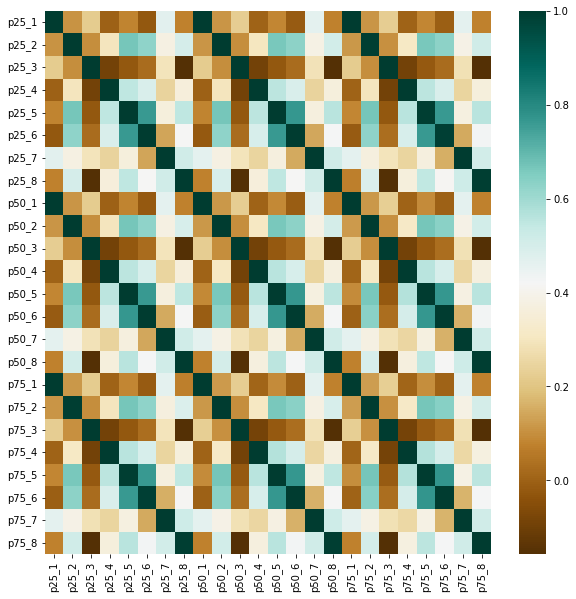

In [112]:
plt.figure(figsize=(10,10))
c = x.corr(method='pearson')
ax = sns.heatmap(c, cmap='BrBG')

In [113]:
corr_features = correlation(x, 0.9)
print(len(set(corr_features)))
print(corr_features)

16
{'p75_1', 'p50_3', 'p50_4', 'p75_3', 'p75_6', 'p50_1', 'p75_4', 'p75_5', 'p50_8', 'p50_6', 'p75_7', 'p50_7', 'p50_2', 'p75_8', 'p75_2', 'p50_5'}


In [114]:
pearson_25_50_75 = x[['p75_1', 'p50_3', 'p50_4', 'p75_3', 'p75_6', 'p50_1', 'p75_4', 'p75_5', 'p50_8', 'p50_6', 'p75_7', 'p50_7', 'p50_2', 'p75_8', 'p75_2', 'p50_5']]
pearson_25_50_75

,p75_1,p50_3,p50_4,p75_3,p75_6,p50_1,p75_4,p75_5,p50_8,p50_6,p75_7,p50_7,p50_2,p75_8,p75_2,p50_5
0,396.260219,370.261831,566.789424,372.453904,861.385758,390.969568,568.767215,807.699092,430.917420,857.248045,466.483487,461.082934,509.969388,433.744323,510.536111,802.923758
1,467.583570,517.091274,577.648187,519.653918,819.103419,464.478206,578.732049,819.544392,492.307762,816.659711,542.537408,539.645653,436.880899,496.233261,445.956250,818.816670
2,397.113122,467.646101,565.489789,471.026856,786.576996,394.588985,566.828858,785.825314,472.503175,782.049393,512.422274,510.827986,378.193616,476.990794,381.889571,783.732483
3,335.534931,379.447810,543.500903,382.124047,601.259363,334.144480,545.017602,664.578772,437.216263,594.442590,476.242875,475.578889,342.757916,437.599661,345.514467,661.816488
4,311.745394,363.490363,527.861378,364.489402,563.433472,305.980191,529.205002,637.815329,422.546873,557.253756,459.754595,457.277578,309.903151,425.894693,313.053481,635.627665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4628,463.043315,324.363549,339.616487,325.275503,629.159778,460.943991,342.867911,383.899166,437.623258,628.324148,424.617687,423.391975,363.783881,446.544159,365.425987,381.370928
4629,457.215763,321.099608,321.015218,322.096278,638.838537,453.114345,322.217235,383.302036,434.788153,636.604734,427.159323,425.515698,329.923243,436.635927,331.156585,380.220258
4630,480.449289,329.112233,329.919435,333.377541,650.885299,478.399120,332.122595,397.494390,463.057025,647.772120,453.768310,448.781863,317.573142,467.517040,319.390849,395.768394
4631,490.327980,334.633752,334.082106,334.666265,681.801458,487.344860,334.559882,403.052502,473.131489,675.061219,466.406919,464.091467,316.953847,474.796263,317.100447,401.428801


In [115]:
x = pearson_25_50_75
y = data_y

scaler = StandardScaler()
scaler.fit(x, y)

cv = KFold(n_splits=10, random_state=1, shuffle=True)
model =   RandomForestClassifier(n_estimators=64)

scores = cross_val_score(model, x, y, scoring='accuracy',
                         cv=cv, n_jobs=-1)

print("Cross-validation scores: ", scores)
print("Mean cross-validation score: ", scores.mean())

Cross-validation scores:  [0.75862069 0.72844828 0.78448276 0.73434125 0.74946004 0.76673866
 0.76889849 0.79913607 0.73866091 0.76457883]
Mean cross-validation score:  0.7593365978997542


In [117]:
data_sampling = pd.DataFrame(datamean.index)
data_sampling

,sampling_id
0,457.0
1,468.0
2,470.0
3,488.0
4,489.0
...,...
4628,11207.0
4629,11208.0
4630,11209.0
4631,11210.0


In [118]:
data_percentile = data_25_50_75.join(data_sampling)
data_percentile2 = data_percentile.set_index('sampling_id')
data_percentile2

,p25_1,p25_2,p25_3,p25_4,p25_5,p25_6,p25_7,p25_8,p50_1,p50_2,...,p50_7,p50_8,p75_1,p75_2,p75_3,p75_4,p75_5,p75_6,p75_7,p75_8
sampling_id,,,,,,,,,,,,,,,,,,,,,
457.0,390.107524,509.042084,367.567556,566.170117,798.447868,850.516956,460.528664,427.031137,390.969568,509.969388,...,461.082934,430.917420,396.260219,510.536111,372.453904,568.767215,807.699092,861.385758,466.483487,433.744323
468.0,460.019233,429.006553,515.215619,575.065356,817.568311,815.852174,534.958685,488.307430,464.478206,436.880899,...,539.645653,492.307762,467.583570,445.956250,519.653918,578.732049,819.544392,819.103419,542.537408,496.233261
470.0,389.036647,374.929696,460.991003,563.522717,780.607637,776.456017,508.803359,468.804797,394.588985,378.193616,...,510.827986,472.503175,397.113122,381.889571,471.026856,566.828858,785.825314,786.576996,512.422274,476.990794
488.0,329.837205,335.537698,374.781553,539.575210,657.146902,585.475162,472.497240,435.546707,334.144480,342.757916,...,475.578889,437.216263,335.534931,345.514467,382.124047,545.017602,664.578772,601.259363,476.242875,437.599661
489.0,302.259029,306.975608,361.574691,526.270795,632.452370,551.037959,453.274600,418.663968,305.980191,309.903151,...,457.277578,422.546873,311.745394,313.053481,364.489402,529.205002,637.815329,563.433472,459.754595,425.894693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11207.0,458.572626,361.793174,323.225259,337.589013,380.140104,627.787664,421.998806,434.368958,460.943991,363.783881,...,423.391975,437.623258,463.043315,365.425987,325.275503,342.867911,383.899166,629.159778,424.617687,446.544159
11208.0,447.419350,327.183503,319.648153,315.013425,374.499470,627.272880,423.300677,430.505279,453.114345,329.923243,...,425.515698,434.788153,457.215763,331.156585,322.096278,322.217235,383.302036,638.838537,427.159323,436.635927
11209.0,476.347158,317.049592,326.328250,328.292583,395.291657,645.620330,443.678582,458.681483,478.399120,317.573142,...,448.781863,463.057025,480.449289,319.390849,333.377541,332.122595,397.494390,650.885299,453.768310,467.517040


In [119]:
data_kur_skew = data_kurto_skew.join(data_sampling)
data_kur_skew2 = data_kur_skew.set_index('sampling_id')
data_kur_skew2

,kurto_1,kurto_2,kurto_3,kurto_4,kurto_4,kurto_6,kurto_7,kurto_8,skew_1,skew_2,skew_3,skew_4,skew_5,skew_6,skew_7,skew_8
sampling_id,,,,,,,,,,,,,,,,
457.0,0.241168,2.159991,-0.236467,-0.386381,-1.420769,-1.388626,-0.310259,-0.310521,1.229273,-1.176686,0.441888,0.867905,0.131750,-0.170659,1.097907,0.332437
468.0,-0.430487,-0.454865,-0.362496,-0.483649,1.304981,1.108756,-0.021883,-0.992027,-0.532521,0.579314,0.458325,-0.608500,0.414487,0.995355,0.565812,-0.448172
470.0,-1.014392,-0.999999,-0.995165,0.127262,-0.595835,-1.146970,-0.219819,-1.271172,0.079328,0.285705,-0.514921,0.079166,0.083955,0.015651,0.499006,-0.088576
488.0,1.104540,0.024978,-1.305415,-0.499669,-0.279872,-0.588891,0.560896,1.401240,-1.257268,-0.973255,-0.438085,-0.681965,-0.666743,-0.373321,-1.086566,-0.754132
489.0,-1.117622,0.546995,0.449647,2.716525,-0.247827,-0.964435,-1.291085,-1.061487,0.413222,-0.574187,0.888170,-0.611418,0.612526,0.226646,-0.165936,0.154700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11207.0,3.624152,0.195337,0.294111,-0.432151,1.281967,2.338997,1.514349,-1.030144,-0.965796,0.212103,0.573797,0.680878,1.304277,1.846372,-1.239905,0.215334
11208.0,-0.641451,-0.408211,3.559132,-1.024523,-1.251497,-1.542065,-0.002567,-0.237233,-0.074469,-0.773883,1.922795,-0.619974,-0.009297,-0.331972,0.684530,0.521839
11209.0,1.947420,-1.052082,-0.854026,-0.597139,0.180727,-1.106777,-0.982183,-0.539559,-1.402286,0.672384,-0.151580,-0.181276,-0.174720,-0.268693,-0.223312,-0.383616


In [120]:
data_full1 = data_mean_min_max_std.join(data_kur_skew2)
data_full = data_full1.join(data_percentile2)
data_full

,mean_1,mean_2,mean_3,mean_4,mean_5,mean_6,mean_7,mean_8,min_1,min_2,...,p50_7,p50_8,p75_1,p75_2,p75_3,p75_4,p75_5,p75_6,p75_7,p75_8
sampling_id,,,,,,,,,,,,,,,,,,,,,
457.0,393.137241,509.189509,370.495838,567.461768,802.872233,856.153601,463.664560,431.143720,388.377717,500.834177,...,461.082934,430.917420,396.260219,510.536111,372.453904,568.767215,807.699092,861.385758,466.483487,433.744323
468.0,463.723509,439.126817,517.667072,577.075219,818.685740,817.824619,539.324706,491.703297,452.216816,422.582567,...,539.645653,492.307762,467.583570,445.956250,519.653918,578.732049,819.544392,819.103419,542.537408,496.233261
470.0,393.946770,378.544319,465.915204,565.258241,783.431697,781.810517,510.880197,472.616792,385.785601,372.635110,...,510.827986,472.503175,397.113122,381.889571,471.026856,566.828858,785.825314,786.576996,512.422274,476.990794
488.0,331.772989,339.837946,378.295144,542.133611,660.706066,592.709704,473.856209,436.165222,313.730289,319.035253,...,475.578889,437.216263,335.534931,345.514467,382.124047,545.017602,664.578772,601.259363,476.242875,437.599661
489.0,307.225627,309.957133,363.514458,527.743689,635.721924,557.644793,456.747090,422.458127,299.760006,295.900623,...,457.277578,422.546873,311.745394,313.053481,364.489402,529.205002,637.815329,563.433472,459.754595,425.894693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11207.0,460.849549,363.771381,324.444130,340.357980,382.374903,629.912493,422.772413,439.765928,442.351248,357.682987,...,423.391975,437.623258,463.043315,365.425987,325.275503,342.867911,383.899166,629.159778,424.617687,446.544159
11208.0,452.506502,328.761260,321.818051,318.986439,379.123369,633.865161,425.917673,434.656908,440.706546,321.008543,...,425.515698,434.788153,457.215763,331.156585,322.096278,322.217235,383.302036,638.838537,427.159323,436.635927
11209.0,477.878824,318.227317,329.449576,329.982037,396.100635,647.879030,448.407895,462.604242,467.572680,316.891245,...,448.781863,463.057025,480.449289,319.390849,333.377541,332.122595,397.494390,650.885299,453.768310,467.517040


# Random Forest

In [127]:
x = data_full
y = data_y

scaler = StandardScaler()
scaler.fit(x, y)

cv = KFold(n_splits=5,random_state=1, shuffle=True)
model =   RandomForestClassifier(n_estimators=64)

scores = cross_val_score(model, x, y, scoring='accuracy',
                         cv=cv, n_jobs=-1)

print("Cross-validation scores: ", scores)
print("Mean cross-validation score: ", scores.mean())

Cross-validation scores:  [0.74541532 0.7583603  0.76159655 0.7775378  0.75485961]
Mean cross-validation score:  0.7595539152984266


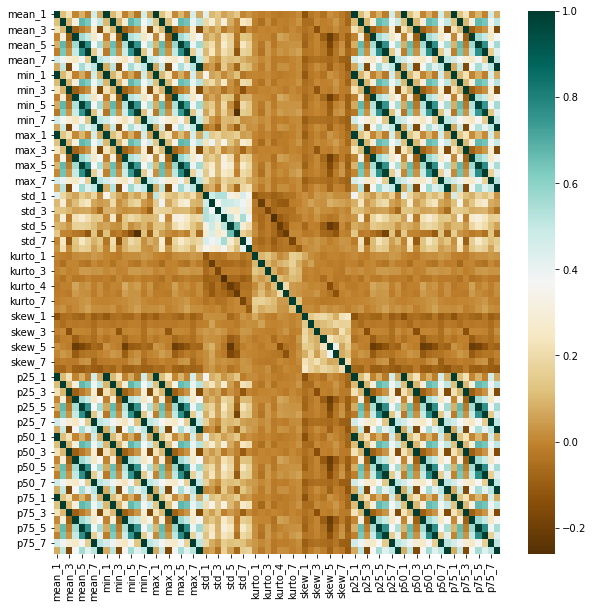

In [128]:
plt.figure(figsize=(10,10))
c = x.corr(method='pearson')
ax = sns.heatmap(c, cmap='BrBG')

In [123]:
corr_features = correlation(x, 0.9)
print(len(set(corr_features)))
print(corr_features)

40
{'max_2', 'p50_3', 'max_3', 'min_4', 'p75_5', 'min_2', 'p75_7', 'p25_4', 'p75_2', 'p50_5', 'min_3', 'max_8', 'max_5', 'p50_4', 'p50_1', 'min_6', 'p25_3', 'p75_4', 'max_1', 'p50_8', 'p50_7', 'min_1', 'p25_7', 'p75_1', 'min_5', 'p25_6', 'p50_6', 'max_7', 'p50_2', 'p75_8', 'min_8', 'p25_8', 'p25_1', 'p25_5', 'p75_6', 'p25_2', 'min_7', 'max_4', 'p75_3', 'max_6'}


In [124]:
pearson_rf = x[['max_2', 'p50_3', 'max_3', 'min_4', 'p75_5', 'min_2', 'p75_7', 'p25_4', 'p75_2', 'p50_5', 'min_3', 'max_8', 'max_5', 'p50_4', 'p50_1', 'min_6', 'p25_3', 'p75_4', 'max_1', 'p50_8', 'p50_7', 'min_1', 'p25_7', 'p75_1', 'min_5', 'p25_6', 'p50_6', 'max_7', 'p50_2', 'p75_8', 'min_8', 'p25_8', 'p25_1', 'p25_5', 'p75_6', 'p25_2', 'min_7', 'max_4', 'p75_3', 'max_6']]
pearson_rf

,max_2,p50_3,max_3,min_4,p75_5,min_2,p75_7,p25_4,p75_2,p50_5,...,min_8,p25_8,p25_1,p25_5,p75_6,p25_2,min_7,max_4,p75_3,max_6
sampling_id,,,,,,,,,,,,,,,,,,,,,
457.0,516.170401,370.261831,381.734848,565.748299,807.699092,500.834177,466.483487,566.170117,510.536111,802.923758,...,423.125335,427.031137,390.107524,798.447868,861.385758,509.042084,459.076430,571.660755,372.453904,864.086551
468.0,464.627151,517.091274,526.313975,571.539962,819.544392,422.582567,542.537408,575.065356,445.956250,818.816670,...,481.139507,488.307430,460.019233,817.568311,819.103419,429.006553,531.664873,580.509717,519.653918,828.287190
470.0,388.347610,467.646101,475.928823,560.979480,785.825314,372.635110,512.422274,563.522717,381.889571,783.732483,...,463.346211,468.804797,389.036647,780.607637,786.576996,374.929696,506.245063,572.840179,471.026856,792.126409
488.0,353.081895,379.447810,383.460187,533.087671,664.578772,319.035253,476.242875,539.575210,345.514467,661.816488,...,427.490511,435.546707,329.837205,657.146902,601.259363,335.537698,463.699898,549.558820,382.124047,611.959774
489.0,317.308239,363.490363,369.856269,519.768093,637.815329,295.900623,459.754595,526.270795,313.053481,635.627665,...,416.392049,418.663968,302.259029,632.452370,563.433472,306.975608,451.150338,532.181282,364.489402,575.037202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11207.0,372.283886,324.363549,328.739677,336.148125,383.899166,357.682987,424.617687,337.589013,365.425987,381.370928,...,426.014357,434.368958,458.572626,380.140104,629.159778,361.793174,414.979035,348.265053,325.275503,641.434324
11208.0,336.049021,321.099608,334.988706,311.470556,383.302036,321.008543,427.159323,315.013425,331.156585,380.220258,...,426.761060,430.505279,447.419350,374.499470,638.838537,327.183503,420.063466,327.184237,322.096278,642.089469
11209.0,320.981292,329.112233,336.140151,323.822445,397.494390,316.891245,453.768310,328.292583,319.390849,395.768394,...,447.864268,458.681483,476.347158,395.291657,650.885299,317.049592,435.836697,334.876286,333.377541,652.815537


In [129]:
x = pearson_rf
y = data_y

scaler = StandardScaler()
scaler.fit(x, y)

cv = KFold(n_splits=5, random_state=1, shuffle=True)
model =   RandomForestClassifier(n_estimators=64)

scores = cross_val_score(model, x, y, scoring='accuracy',
                         cv=cv, n_jobs=-1)

print("Cross-validation scores: ", scores)
print("Mean cross-validation score: ", scores.mean())

Cross-validation scores:  [0.74433657 0.76914779 0.74865156 0.77645788 0.75917927]
Mean cross-validation score:  0.759554614271635


# Decisian Tree

In [130]:
x = data_mean_min_max_std
y = data_y

scaler = StandardScaler()
scaler.fit(x, y)

cv = KFold(n_splits=5, random_state=1, shuffle=True)
model =   DecisionTreeClassifier()

scores = cross_val_score(model, x, y, scoring='accuracy',
                         cv=cv, n_jobs=-1)

print("Cross-validation scores: ", scores)
print("Mean cross-validation score: ", scores.mean())

Cross-validation scores:  [0.65803668 0.6763754  0.65156419 0.65442765 0.6587473 ]
Mean cross-validation score:  0.659830242706797


In [131]:
x = data_kurto_skew
y = data_y

scaler = StandardScaler()
scaler.fit(x, y)

cv = KFold(n_splits=10, random_state=1, shuffle=True)
model =   DecisionTreeClassifier()

scores = cross_val_score(model, x, y, scoring='accuracy',
                         cv=cv, n_jobs=-1)

print("Cross-validation scores: ", scores)
print("Mean cross-validation score: ", scores.mean())

Cross-validation scores:  [0.54956897 0.5625     0.56896552 0.6112311  0.56155508 0.54859611
 0.57019438 0.57883369 0.59179266 0.55291577]
Mean cross-validation score:  0.5696153273255381


In [132]:
x = data_full
y = data_y

scaler = StandardScaler()
scaler.fit(x, y)

cv = KFold(n_splits=5, random_state=1, shuffle=True)
model =   DecisionTreeClassifier()

scores = cross_val_score(model, x, y, scoring='accuracy',
                         cv=cv, n_jobs=-1)

print("Cross-validation scores: ", scores)
print("Mean cross-validation score: ", scores.mean())

Cross-validation scores:  [0.64940669 0.64832794 0.64724919 0.64362851 0.6663067 ]
Mean cross-validation score:  0.6509838047907623


# KNN

In [133]:
x = data_full
y = data_y

scaler = StandardScaler()
scaler.fit(x, y)

cv = KFold(n_splits=5, random_state=1, shuffle=True)
model =   KNeighborsClassifier()

scores = cross_val_score(model, x, y, scoring='accuracy',
                         cv=cv, n_jobs=-1)

print("Cross-validation scores: ", scores)
print("Mean cross-validation score: ", scores.mean())

Cross-validation scores:  [0.73570658 0.7605178  0.73247033 0.77105832 0.73434125]
Mean cross-validation score:  0.7468188564332329


# SVM

In [135]:
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
x = data_full
y = data_y

param_grid = {
#     'reduce_dim__n_components':[10],
    'model__C'    : [1,10,100],
    'model__gamma': ['auto'],
            }
pipe = Pipeline([('standardscaler',StandardScaler()),
#                     ('reduce_dim',PCA()),
                 ('model',SVC())
#                     ('model',KNeighborsClassifier(n_neighbors=4))
#                     ('model', GaussianNB())
#                    ('model', DecisionTreeClassifier())
#                     ('model', RandomForestClassifier(max_depth=2, random_state=0))
#                     ('model', LinearDiscriminantAnalysis())
                ])
grid = GridSearchCV(pipe,param_grid=param_grid,cv=cv,
                    scoring='accuracy', n_jobs=-1)


grid.fit(x,y)
scores = cross_val_score(grid.best_estimator_, 
                         x, y, 
                        cv=cv)
print("Cross-validation scores: ", scores)
print("Mean cross-validation score: ", scores.mean()) 
print("parameter%s",grid.best_params_)

Cross-validation scores:  [0.73247033 0.75943905 0.74757282 0.78293737 0.73434125]
Mean cross-validation score:  0.7513521636715665
parameter%s {'model__C': 1, 'model__gamma': 'auto'}


In [136]:
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
x = data_full
y = data_y

param_grid = {
    'reduce_dim__n_components':[3],
    'model__C'    : [1,10,100],
    'model__gamma': ["auto"],
            }
pipe = Pipeline([('standardscaler',StandardScaler()),
                    ('reduce_dim',PCA()),
                 ('model',SVC())
#                     ('model',KNeighborsClassifier(n_neighbors=4))
#                     ('model', GaussianNB())
#                    ('model', DecisionTreeClassifier())
#                     ('model', RandomForestClassifier(max_depth=2, random_state=0))
#                     ('model', LinearDiscriminantAnalysis())
                ])
grid = GridSearchCV(pipe,param_grid=param_grid,cv=cv,
                    scoring='accuracy', n_jobs=-1)


grid.fit(x,y)
scores = cross_val_score(grid.best_estimator_, 
                         x, y, 
                        cv=cv)
print("Cross-validation scores: ", scores)
print("Mean cross-validation score: ", scores.mean()) 
print("parameter%s",grid.best_params_)

Cross-validation scores:  [0.72168285 0.73786408 0.74002157 0.74946004 0.72030238]
Mean cross-validation score:  0.7338661839091708
parameter%s {'model__C': 1, 'model__gamma': 'auto', 'reduce_dim__n_components': 3}


# DNN

In [140]:
import tensorflow as tf
import keras
from tensorflow.keras.layers import Dense, Dropout, InputLayer
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

In [137]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
y_dnn = ohe.fit_transform(data_y.values.reshape(-1,1)).toarray()
y_dnn

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

TRAIN: [ 831  834  835 ... 4630 4631 4632] TEST: [   0    1    2    3    4    5    6    7    8    9   10   11   12   13
   14   15   16   17   18   19   20   21   22   23   24   25   26   27
   28   29   30   31   32   33   34   35   36   37   38   39   40   41
   42   43   44   45   46   47   48   49   50   51   52   53   54   55
   56   57   58   59   60   61   62   63   64   65   66   67   68   69
   70   71   72   73   74   75   76   77   78   79   80   81   82   83
   84   85   86   87   88   89   90   91   92   93   94   95   96   97
   98   99  100  101  102  103  104  105  106  107  108  109  110  111
  112  113  114  115  116  117  118  119  120  121  122  123  124  125
  126  127  128  129  130  131  132  133  134  135  136  137  138  139
  140  141  142  143  144  145  146  147  148  149  150  151  152  153
  154  155  156  157  158  159  160  161  162  163  164  165  166  167
  168  169  170  171  172  173  174  175  176  177  178  179  180  181
  182  183  184  185  186  1

29/29 [==============================] - 0s 3ms/step


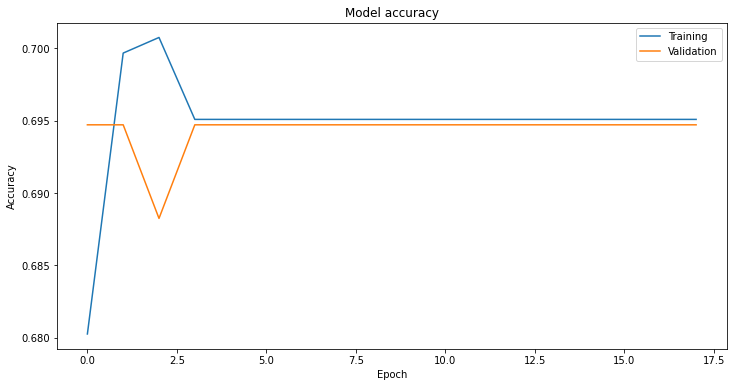

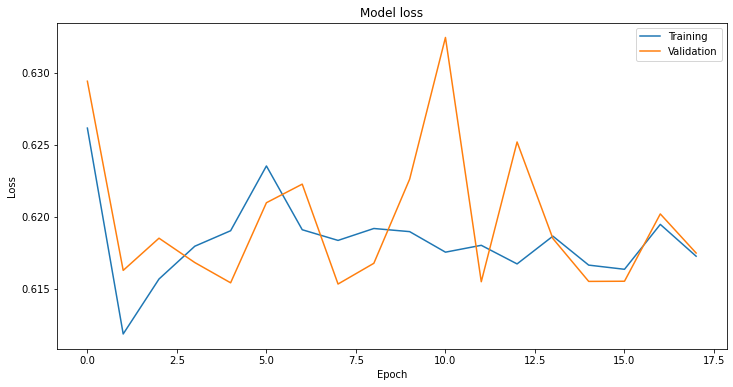

TRAIN: [   0    1    2 ... 4630 4631 4632] TEST: [ 831  834  835  836  837  838  839  845  850  851  852  853  854  855
  856  857  858  859  860  861  862  863  864  865  866  867  868  869
  870  871  878  881  886  887  892  893  895  900  903  911  913  915
  919  921  924  930  932  941  942  943  944  945  946  949  950  952
  953  955  957  961  964  968  970  972  973  976  980  982  983  985
  986  994  995  996  997  999 1000 1001 1002 1003 1006 1007 1009 1010
 1011 1012 1013 1014 1015 1016 1017 1018 1019 1020 1021 1022 1023 1024
 1025 1026 1027 1028 1029 1030 1031 1032 1033 1034 1035 1036 1037 1038
 1039 1040 1041 1042 1043 1044 1045 1046 1047 1048 1049 1050 1051 1052
 1053 1054 1055 1056 1057 1058 1059 1060 1061 1062 1063 1064 1065 1066
 1067 1068 1069 1070 1071 1072 1073 1074 1075 1076 1077 1078 1079 1080
 1081 1082 1083 1084 1085 1086 1087 1088 1089 1090 1091 1092 1093 1094
 1095 1096 1097 1098 1099 1100 1101 1102 1103 1104 1105 1106 1107 1108
 1109 1110 1111 1112 1113 11

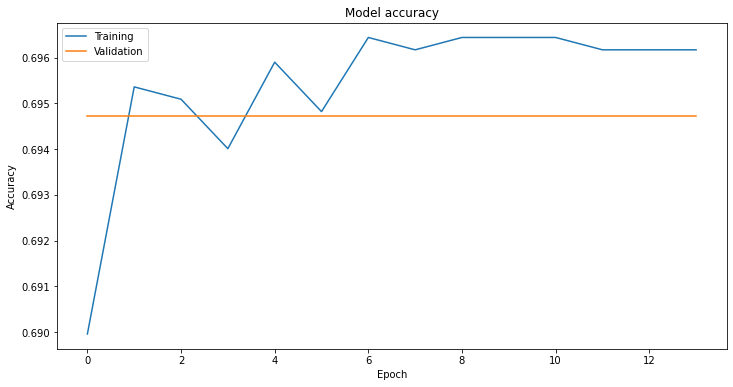

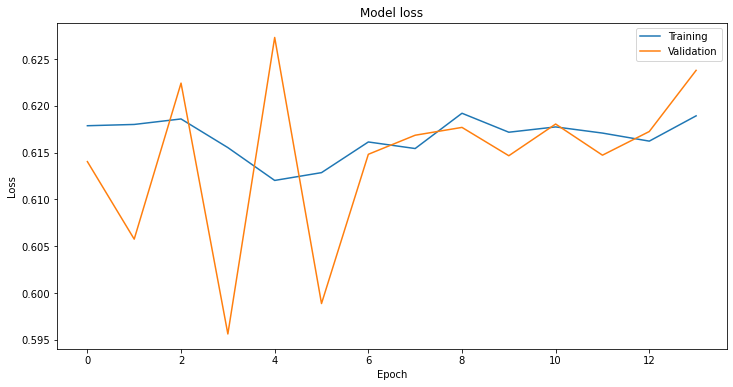

TRAIN: [   0    1    2 ... 4630 4631 4632] TEST: [1350 1351 1352 1353 1354 1357 1360 1361 1362 1363 1368 1371 1372 1373
 1375 1377 1378 1379 1381 1387 1389 1390 1392 1398 1402 1406 1407 1408
 1409 1410 1412 1413 1414 1417 1418 1420 1423 1428 1430 1431 1435 1436
 1437 1438 1441 1444 1445 1447 1450 1451 1457 1459 1463 1464 1469 1472
 1476 1477 1479 1480 1482 1483 1484 1485 1486 1490 1494 1510 1511 1512
 1517 1520 1522 1523 1524 1526 1527 1528 1529 1533 1539 1540 1541 1542
 1547 1548 1549 1552 1553 1554 1560 1562 1564 1565 1566 1567 1568 1569
 1571 1575 1577 1578 1579 1580 1582 1583 1584 1585 1586 1590 1593 1594
 1595 1596 1597 1598 1603 1604 1605 1606 1609 1612 1614 1615 1616 1622
 1623 1624 1625 1628 1629 1630 1631 1634 1635 1636 1638 1639 1640 1641
 1642 1644 1645 1646 1648 1649 1650 1651 1652 1656 1659 1660 1661 1662
 1665 1666 1667 1668 1671 1672 1673 1674 1678 1679 1680 1681 1683 1686
 1687 1689 1690 1691 1693 1694 1695 1696 1697 1698 1699 1702 1703 1706
 1708 1709 1710 1711 1712 17

Epoch 19/100
116/116 [==============================] - 1s 5ms/step - loss: 0.6160 - accuracy: 0.6964 - val_loss: 0.6154 - val_accuracy: 0.6947
Epoch 20/100
116/116 [==============================] - 1s 5ms/step - loss: 0.6175 - accuracy: 0.6956 - val_loss: 0.6154 - val_accuracy: 0.6947
Epoch 21/100
116/116 [==============================] - 1s 6ms/step - loss: 0.6166 - accuracy: 0.6962 - val_loss: 0.6156 - val_accuracy: 0.6947
Epoch 22/100
116/116 [==============================] - 1s 6ms/step - loss: 0.6160 - accuracy: 0.6962 - val_loss: 0.6185 - val_accuracy: 0.6947
Epoch 23/100
116/116 [==============================] - 1s 6ms/step - loss: 0.6159 - accuracy: 0.6956 - val_loss: 0.6195 - val_accuracy: 0.6947
Epoch 24/100
116/116 [==============================] - 1s 4ms/step - loss: 0.6160 - accuracy: 0.6962 - val_loss: 0.6160 - val_accuracy: 0.6947
Epoch 25/100
116/116 [==============================] - 1s 5ms/step - loss: 0.6152 - accuracy: 0.6964 - val_loss: 0.6161 - val_accuracy:

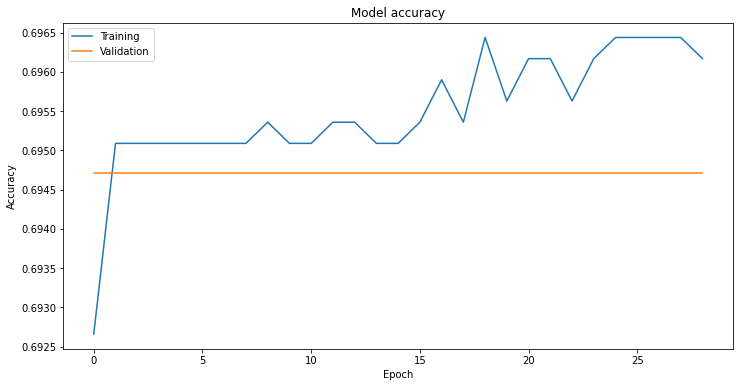

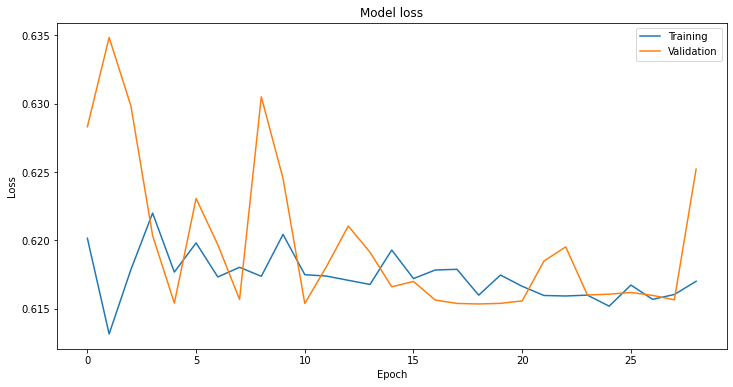

TRAIN: [   0    1    2 ... 4630 4631 4632] TEST: [1879 1880 1888 1891 1895 1896 1898 1899 1901 1902 1903 1904 1905 1908
 1909 1910 1912 1913 1916 1917 1918 1920 1924 1925 1926 1929 1933 1937
 1938 1939 1940 1941 1942 1943 1945 1948 1949 1951 1952 1955 1957 1959
 1961 1963 1965 1967 1968 1969 1972 1974 1975 1977 1979 1981 1983 1986
 1992 1994 1997 1998 1999 2000 2003 2004 2007 2014 2019 2021 2023 2025
 2028 2035 2037 2038 2040 2049 2056 2065 2066 2069 2071 2073 2077 2081
 2082 2088 2089 2091 2093 2097 2102 2106 2112 2113 2115 2117 2122 2129
 2132 2133 2136 2139 2144 2145 2150 2153 2156 2158 2161 2164 2165 2166
 2167 2174 2181 2183 2185 2196 2206 2208 2213 2215 2217 2218 2219 2220
 2221 2223 2225 2226 2229 2240 2241 2250 2252 2262 2273 2280 2284 2285
 2286 2287 2290 2292 2301 2307 2309 2310 2312 2315 2316 2317 2318 2320
 2331 2332 2333 2345 2351 2352 2353 2360 2363 2366 2367 2372 2374 2379
 2387 2394 2398 2402 2403 2406 2414 2415 2417 2420 2422 2423 2425 2430
 2431 2434 2436 2451 2453 24

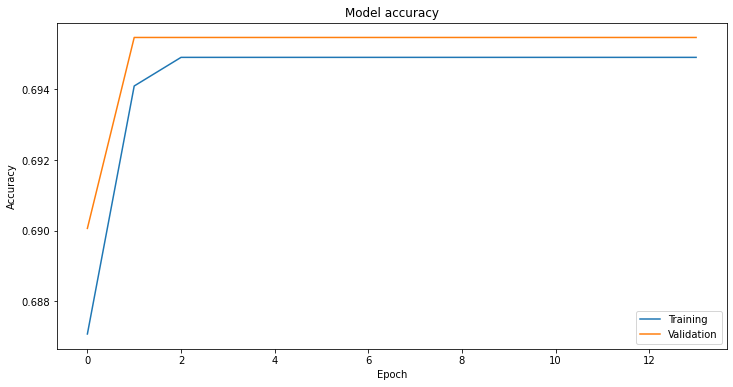

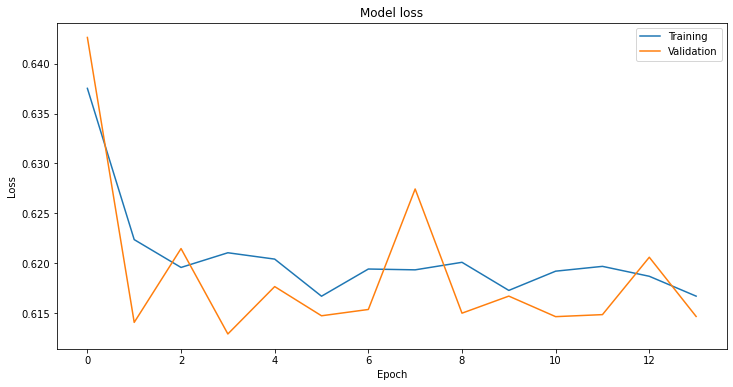

TRAIN: [   0    1    2 ... 3834 3835 3836] TEST: [2888 2891 2904 2914 2919 2920 2921 2925 2931 2934 2936 2943 2954 2956
 2965 2971 2974 2976 2983 2985 2988 2990 3006 3011 3017 3019 3024 3030
 3036 3042 3044 3045 3048 3052 3070 3075 3080 3085 3092 3094 3097 3111
 3114 3116 3118 3127 3129 3143 3167 3177 3183 3192 3193 3197 3202 3206
 3210 3215 3218 3229 3231 3233 3248 3251 3271 3279 3286 3289 3294 3301
 3303 3311 3322 3332 3334 3342 3344 3362 3366 3369 3388 3390 3401 3418
 3419 3423 3439 3440 3441 3456 3458 3489 3490 3491 3492 3503 3520 3522
 3530 3535 3548 3561 3562 3563 3566 3571 3574 3575 3599 3615 3617 3675
 3702 3703 3713 3714 3716 3717 3720 3726 3729 3743 3757 3764 3765 3770
 3780 3787 3824 3832 3837 3838 3839 3840 3841 3842 3843 3844 3845 3846
 3847 3848 3849 3850 3851 3852 3853 3854 3855 3856 3857 3858 3859 3860
 3861 3862 3863 3864 3865 3866 3867 3868 3869 3870 3871 3872 3873 3874
 3875 3876 3877 3878 3879 3880 3881 3882 3883 3884 3885 3886 3887 3888
 3889 3890 3891 3892 3893 38

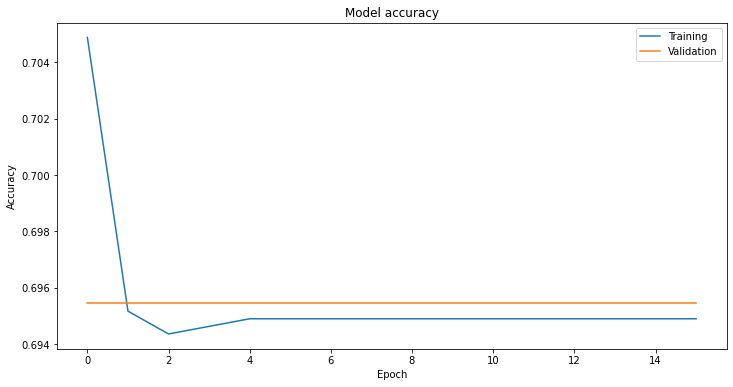

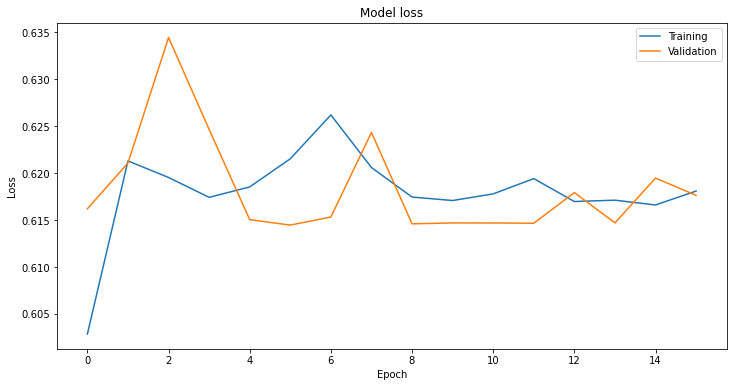

In [141]:
from keras.callbacks import EarlyStopping
pred_chi = []
test_chi = []
data_x = data_full

# get_n_split = int(split_n(len(X_chi)))
# skf = StratifiedKFold(n_splits=get_n_split)
skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(data_x, data_y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train_chi, X_test_chi = data_x.iloc[train_index], data_x.iloc[test_index]
    y_train_chi, y_test_chi = y_dnn[train_index], y_dnn[test_index]

    print(X_train_chi.shape, y_train_chi.shape)
    print(X_test_chi.shape, y_test_chi.shape)

    ### create the model

    model_chi = Sequential()
    model_chi.add(InputLayer(input_shape=(X_train_chi.shape[1],))) #Input Layer
    
    model_chi.add(Dense(X_train_chi.shape[1], activation='tanh')) #Hidden Layer 1 
    model_chi.add(Dense(X_train_chi.shape[1], activation='tanh')) #Hidden Layer 2
    
    model_chi.add(Dense(y_train_chi.shape[1], activation='softmax')) #Output Layer
    model_chi.summary()

    model_chi.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

    history = model_chi.fit(X_train_chi, y_train_chi,validation_data=(X_test_chi, y_test_chi),
                    # shuffle=True,
                  epochs=100,
                  callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

    history_dict = history.history
    print(history_dict.keys())


    ### predict the model 

    y_pred_chi = model_chi.predict(X_test_chi)
    # pred_chi = []
    for i in range(len(y_pred_chi)):
        pred_chi.append(np.argmax(y_pred_chi[i]))

    # test_chi = []
    for i in range(len(y_test_chi)):
        test_chi.append(np.argmax(y_test_chi[i]))


    ### plot the model

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()


    plt.plot(history.history['loss'],label='Training')
    plt.plot(history.history['val_loss'],label='Validation')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [142]:
from sklearn.metrics import accuracy_score
accuracy_score(test_chi,pred_chi)

0.6950140297863155

In [143]:
from sklearn.metrics import classification_report

print(classification_report(test_chi,pred_chi))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1413
           1       0.70      1.00      0.82      3220

    accuracy                           0.70      4633
   macro avg       0.35      0.50      0.41      4633
weighted avg       0.48      0.70      0.57      4633



C:\Users\ASUS\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [144]:
from sklearn.metrics import confusion_matrix

confusion_matrix(test_chi,pred_chi)

array([[   0, 1413],
       [   0, 3220]], dtype=int64)

<AxesSubplot:>

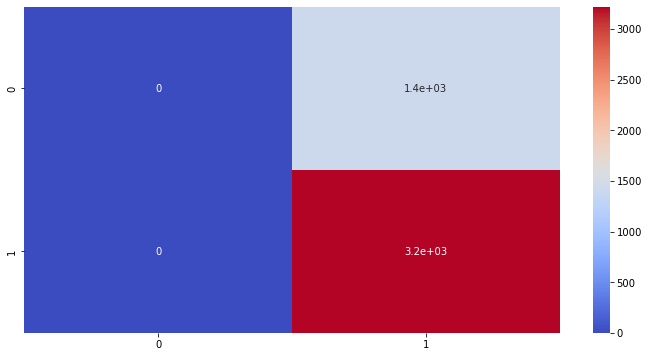

In [145]:
import seaborn as sns
cm = confusion_matrix(test_chi,pred_chi)
sns.heatmap(cm,annot=True,cmap='coolwarm')

# PCA

In [70]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(x)

In [71]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.95)
pca.fit(data_rescaled)
reduced = pca.transform(data_rescaled)

In [79]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
print("original shape:   ", x.shape)
print("transformed shape:", principalComponents.shape)
principalDf = pd.DataFrame(principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3'])

# finalDf = pd.concat([principalDf, data_y], axis = 1)

print(principalDf,data_y)

original shape:    (4633, 16)
transformed shape: (4633, 3)
      principal component 1  principal component 2  principal component 3
0                343.003373             110.443967             -39.012279
1                328.571252             314.991185            -135.366518
2                203.391981             237.319505             -75.886537
3               -113.155131             232.282279              48.974948
4               -190.034540             215.604329              60.259450
...                     ...                    ...                    ...
4628            -247.985447             218.913441              -1.141642
4629            -281.930807             220.459351              -4.648961
4630            -249.839862             244.907605              11.637947
4631            -210.324259             257.444838              10.999236
4632            -147.722322             272.047956              13.650540

[4633 rows x 3 columns] sampling_id
457.0      1.0
4

In [82]:
x = principalDf
y = data_y

scaler = StandardScaler()
scaler.fit(x, y)

cv = KFold(n_splits=5, random_state=1, shuffle=True)
model =   RandomForestClassifier(n_estimators=64)

scores = cross_val_score(model, x, y, scoring='accuracy',
                         cv=cv, n_jobs=-1)

print("Cross-validation scores: ", scores)
print("Mean cross-validation score: ", scores.mean())

Cross-validation scores:  [0.70981661 0.7206041  0.70118662 0.7224622  0.70410367]
Mean cross-validation score:  0.7116346420441704
